In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from functools import reduce
import re as re
import datetime
from matplotlib.backends.backend_pdf import PdfPages
from itertools import permutations
sns.set()


In [2]:
# Importing the file

class HDX(object):
    
    def __init__(self, df, states_list):
        
        self.states_list = states_list
        
        self.df = df


    def rename_states(self):
        """
        df = dataframe, states_list is a list of states you want to rename

        """
        
        states = self.df['Protein State'].unique()

        state_renames ={}

        for st, stls in zip(states, self.states_list):

            state_renames[st] =stls

        self.df['Protein State'].replace(state_renames, inplace=True)

        return df


    def protein_states(self):

        """
        df = dataframe, states_list is a list of your preferred names for states
        The 'states_list' has to be the same as rename_state(df, "states_list)

        """
        df = self.rename_states()
        
        states = list(df['Protein State'].unique())

        frames =[]

        for i in states:
            i = df[df['Protein State']==i]
            frames.append(i)

        #for df in frames:
            #self.df.drop('Protein State', axis =1)

        rnst =[]
        
        for i in states:
            
            i = "_"+ i
            
            rnst.append(i)

        df = reduce(lambda  left,right: pd.merge(left,right,on=['Start', 'End', 'Sequence', 'Deut Time (sec)', 'maxD'],
                                              how='outer', suffixes= tuple(rnst[:-1])), frames)

        colnames = list(df.columns)

        # Renaming the columns of the state so that it matches with the other states
        new_names = [i + "_" + self.states_list[-1] for i in colnames[-8:]]

        maps={}

        for i, j in zip(colnames[-8:], new_names):
            
            maps[i] =j

        df= df.rename(columns= maps)

        return df

    def processed_df(self):
        
        df1 = self.protein_states()

        # indexing unique peptides from 1.
        idx = range(1,1+len([i for i in df1['Sequence'].unique()]))

        idx_dict = {idx: i for (idx, i) in zip(idx, df1['Sequence'].unique())}

        df1['idx_pep'] = [idx for idx, pep in idx_dict.items() for p in df1['Sequence'] if p == pep]

        # New Column containg the unique index number and the start and end of the sequence

        df1['idx']= df1['idx_pep'].astype("str") + df1.Start.astype("str").apply(
            lambda x: " (" + x + "-"
        ) + df1.End.astype("str").apply(
            lambda x: x + ")"
        )

        # New Column containg the peptides, its unique index number and the start and end of the sequence

        df1['peps'] = df1['idx_pep'].astype("str").apply(
            lambda x: x + ". "
        ) + df1['Sequence'] + df1.Start.astype("str").apply(
            lambda x: " (" + x + "-"
        ) + df1.End.astype("str").apply(
            lambda x: x + ")"
        )

        # setting the idx_pep column as the index of the dataframe
        df1.index = df1['idx']

        df1 = df1.drop('idx', axis =1)

        return df1



In [3]:
class col_names(object):
    
    @staticmethod    
    def state_list(states_list):
        
        stls = list(permutations(states_list, 2))
        
        st_li =[]
        
        for i in range(len(stls)):
            
            a = stls[i]
            
            new = a[0]+"_"+a[1]
            
            st_li.append(new)
        
        return st_li
    
    @staticmethod 
    def state_error_list(states_list):
        
        stls = list(permutations(states_list, 2))
        
        stls_error = [(i,'std' ) for i in stls]
        
        st_li_er =[]
        
        for i in range(len(stls_error)):
            
            a,b = stls_error[i]
            
            new = a[0]+"_"+a[1]+ "_" + b
            
            st_li_er.append(new)
            
        return st_li_er

In [4]:
class pep_analyzer(object):
    
    def __init__(self, df, states_list, colnames = col_names):
        
        self.sts_comb = list(permutations(states_list, 2))
        
        self.df = df
        
        self.colnames = colnames
        
        self.states_list = states_list
        
    def cal_diff(self):
        
        # Making new columns named i showing the differences among multiple states  
        
        for i, j in zip(self.colnames.state_list(self.states_list),self.sts_comb):
            
            self.df[i] = self.df["#D_" + j[0]] - self.df["#D_" + j[1]]
            
        # Making new columns named i for the respective errors using standard error propagation rules    
        
        for i, j in zip(self.colnames.state_error_list(self.states_list),self.sts_comb):
                
            self.df[i] = (self.df["Stddev_" + j[0]]**2 + self.df["Stddev_" + j[1]]**2).apply(np.sqrt)
        
        df.to_csv("Processed_HDX_file.csv")
            
        return df
            
    def pep_diff_uptake_class(self, state= ('apo', 'bi'), st1_st2 = True):
        
        df = self.cal_diff()
        
        a= "#D_" + state[0]
        b= "#D_" + state[1]
        
        a1 = df.groupby("idx")[a, b].mean()[a]
        b1 =df.groupby("idx")[a, b].mean()[b]
        
        if st1_st2:
            
            # List of peptides for the complex that has more D than the following complex
            pep = df.peps.unique()[a1>b1]
            pep_idx = df.index.unique()[a1>b1]

        else:
            # List of peptides for the complex that has more D than the following complex
            pep = df.peps.unique()[a1<b1]
            pep_idx = df.index.unique()[a1<b1]

        return pep, pep_idx
    
    def pep_diff_sig_class(self, state= ('apo', 'bi'), st1_st2 = True, er_da=1):
        
        df = self.cal_diff()
        
        st1_st2 = st1_st2
        
        pep, pep_idx = self.pep_diff_uptake_class(state= ('apo', 'bi'), st1_st2 = True)

        col = state[0] + "_" + state[1]
        
        col_error = state[0] + "_" + state[1] +"_std"
        
        if st1_st2:
            
            idx_pep_sig = df.loc[pep_idx][
                (
                    df.loc[pep_idx][col].round(1)
                    >
                    df.loc[pep_idx][col_error].round(1)
                )
                &
                (
                    df.loc[pep_idx][col].round(1)
                    > er_da
                )
            ].index.unique()  

            pep_sig = df.loc[pep_idx][
                (
                    df.loc[pep_idx][col].round(1)
                    >
                    df.loc[pep_idx][col_error].round(1)
                )
                &
                (
                    df.loc[pep_idx][col].round(1)
                    > er_da
                )
            ].peps.unique()
            
        else:
            idx_pep_sig = df.loc[pep_idx][
                (
                    df.loc[pep_idx][col].round(1)
                    <
                    df.loc[pep_idx][col_error].round(1)
                )
                &
                (
                    df.loc[pep_idx][col].round(1)
                    > er_da
                )
            ].index.unique()  

            pep_sig = df.loc[pep_idx][
                (
                    df.loc[pep_idx][col].round(1)
                    <
                    df.loc[pep_idx][col_error].round(1)
                )
                &
                (
                    df.loc[pep_idx][col].round(1)
                    > er_da
                )
            ].peps.unique()
        
        return idx_pep_sig, pep_sig

In [15]:
def import_file(folder_path = "folder_name"):
        
    for file in os.listdir(folder_path):
            
        if file.endswith(".csv"):
                
            filepath = os.path.join(folder_path, file)
                
    df = pd.read_csv(filepath)
        
    return df


In [16]:
df = import_file(folder_path = "Data")

states_list = ["apo", "bi", "tr"]

hdx = HDX(df, states_list)

df = hdx.processed_df()


pepn = pep_analyzer( df, states_list, colnames = col_names)

df = pepn.cal_diff()

In [17]:
dab_pos_sig, dab_pos_sig_pep = pepn.pep_diff_sig_class(state= ('apo',"bi"), st1_st2 = True, er_da=0.5)

In [8]:
# Mapping the residue numbers to the domains of the protein
pep_map = {"WED I": range(1, 1+24), 
                   "REC 1": range(25, 1+339),
                   "REC 2": range(340, 1+591),
                   "WED II": range(592, 1+662),
                   "PI": range(663, 1+762),
                   "WED III": range(763, 1+892),
                   "RuvC I": range(893, 1+953),
                   "BH": range(954, 1+971),
                   "RuvC II": range(972, 1+1078),
                   "NUC": range(1079, 1+1254),
                   "RuvC III": range(1255, 1+1300)}

# Creating list of Start numbers from the "Start" Column
start = list(df.Start)

# Creating list of End numbers from the "End" Column
end = list(df.End)

# Creating a list mapping the start and end numbers to its domain names of the protein using the pep_map Dictionary
sts = []
ens = []
for keys, values in pep_map.items():
    for d in values:
        
        for st in start:
            if st == d:
                sts.append(keys)
            
        for en in end:
            if en == d:
                ens.append(keys)
                
                
# Finding the peptides and its indexes that shares multiple domains.
ov =[]
ov_idx= []
for (idx, i), (dx,j) in zip(enumerate(sts),enumerate(ens)):
    if i!=j:
        ov.append((sts[idx],ens[dx]))
        ov_idx.append(idx)

# now renaming those peptides interms of what overlapping domains they belong to 
ovl =[]            
for a, b in ov:
    i = a+" - "+b
    ovl.append(i)
    
#Finally replacing those overlapping peps names in "sts" list with the new names
for (dx,j), (x,k )in zip(enumerate(ov_idx), enumerate(ovl)):
    sts[j] = k

# Creating a new column in the data frame with domain name
df["domains"] = sts

# Checking if above code generated my desired list names
for i, j in zip(sts, ens):
    print((i,j))
# It looks like it did.

('WED I', 'WED I')
('WED I', 'WED I')
('WED I', 'WED I')
('WED I', 'WED I')
('WED I', 'WED I')
('WED I', 'WED I')
('WED I', 'WED I')
('WED I', 'WED I')
('WED I', 'WED I')
('WED I', 'WED I')
('WED I', 'WED I')
('WED I', 'WED I')
('WED I', 'WED I')
('WED I', 'WED I')
('WED I', 'WED I')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('WED I - REC 1', 'REC 1')
('REC 1', 'REC 1')
('REC 1', 'REC 1')
('

('RuvC III', 'RuvC III')
('RuvC III', 'RuvC III')
('RuvC III', 'RuvC III')
('RuvC III', 'RuvC III')
('RuvC III', 'RuvC III')
('RuvC III', 'RuvC III')
('RuvC III', 'RuvC III')
('RuvC III', 'RuvC III')
('RuvC III', 'RuvC III')
('RuvC III', 'RuvC III')
('RuvC III', 'RuvC III')
('RuvC III', 'RuvC III')
('RuvC III', 'RuvC III')
('RuvC III', 'RuvC III')
('RuvC III', 'RuvC III')
('RuvC III', 'RuvC III')
('RuvC III', 'RuvC III')
('RuvC III', 'RuvC III')
('RuvC III', 'RuvC III')
('RuvC III', 'RuvC III')
('RuvC III', 'RuvC III')
('RuvC III', 'RuvC III')
('RuvC III', 'RuvC III')


In [14]:
class plots():
    
    def __init__(self):
        self.pep_map = {"WED I": range(1, 1+24), 
                           "REC 1": range(25, 1+339),
                           "REC 2": range(340, 1+591),
                           "WED II": range(592, 1+662),
                           "PI": range(663, 1+762),
                           "WED III": range(763, 1+892),
                           "RuvC I": range(893, 1+953),
                           "BH": range(954, 1+971),
                           "RuvC II": range(972, 1+1078),
                           "NUC": range(1079, 1+1254),
                           "RuvC III": range(1255, 1+1300)}
        
    def domains_mapping(self, df, pep_map, check = False):
        
        
        """
        It takes a dataframe(csv file) from HDExaminer and pep_map which is a dictionary
        mapping peptides sequence number to the respective domains name.
        It returns the data frmae with a column name domain
        whose values are mapped domain names of the protein.
        The check argument is just to check if the code runs fine. 
        The default state is False.
        
        """
        

        # Creating list of Start numbers from the "Start" Column
        start = list(df.Start)

        # Creating list of End numbers from the "End" Column
        end = list(df.End)

        # Creating a list mapping the start and end numbers to its domain names of the protein using the pep_map Dictionary
        sts = []
        ens = []
        for keys, values in self.pep_map.items():
            for d in values:

                for st in start:
                    if st == d:
                        sts.append(keys)

                for en in end:
                    if en == d:
                        ens.append(keys)


        # Finding the peptides and its indexes that shares multiple domains.
        ov =[]
        ov_idx= []
        for (idx, i), (dx,j) in zip(enumerate(sts),enumerate(ens)):
            if i!=j:
                ov.append((sts[idx],ens[dx]))
                ov_idx.append(idx)

        # now renaming those peptides interms of what overlapping domains they belong to 
        ovl =[]            
        for a, b in ov:
            i = a+" - "+b
            ovl.append(i)

        #Finally replacing those overlapping peps names in "sts" list with the new names
        for (dx,j), (x,k )in zip(enumerate(ov_idx), enumerate(ovl)):
            sts[j] = k

        # Creating a new column in the data frame with domain name
        df["domains"] = sts
        
        if check:
        # Checking if above code generated my desired list names
            for i, j in zip(sts, ens):
                print((i,j))
        else:
            pass
            # It looks like it did.

        return df
    
    def uptake_plots(self, df ):
        """
        This function will create plots of peptides against log of time.
        The df is the dataframe. The parameter 'states' takes the name 
        of the states to be plotted as a tupel. 
        The parameter 'kind' denotes the number or percent plot.
        It returns plots as a pdf file.
        
        """
        df = self.domains_mapping(df, pep_map = self.pep_map, check = False)
        return df

In [10]:
class plots():
    def __init__(self):
        
        self.pep_map = {"WED I": range(1, 1+24), 
                           "REC 1": range(25, 1+339),
                           "REC 2": range(340, 1+591),
                           "WED II": range(592, 1+662),
                           "PI": range(663, 1+762),
                           "WED III": range(763, 1+892),
                           "RuvC I": range(893, 1+953),
                           "BH": range(954, 1+971),
                           "RuvC II": range(972, 1+1078),
                           "NUC": range(1079, 1+1254),
                           "RuvC III": range(1255, 1+1300)}
        
    def domains_mapping(self, df, pep_map, check = False):
        
        """
        It takes a dataframe(csv file) from HDExaminer and pep_map which is a dictionary
        mapping peptides sequence number to the respective domains name.
        It returns the data frmae with a column name domain
        whose values are mapped domain names of the protein.
        The check argument is just to check if the code runs fine. 
        The default state is False.
        
        """

        # Creating list of Start numbers from the "Start" Column
        start = list(df.Start)

        # Creating list of End numbers from the "End" Column
        end = list(df.End)

        # Creating a list mapping the start and end numbers to its domain names of the protein using the pep_map Dictionary
        sts = []
        ens = []
        for keys, values in self.pep_map.items():
            for d in values:

                for st in start:
                    if st == d:
                        sts.append(keys)

                for en in end:
                    if en == d:
                        ens.append(keys)


        # Finding the peptides and its indexes that shares multiple domains.
        ov =[]
        ov_idx= []
        for (idx, i), (dx,j) in zip(enumerate(sts),enumerate(ens)):
            if i!=j:
                ov.append((sts[idx],ens[dx]))
                ov_idx.append(idx)

        # now renaming those peptides interms of what overlapping domains they belong to 
        ovl =[]            
        for a, b in ov:
            i = a+" - "+b
            ovl.append(i)

        #Finally replacing those overlapping peps names in "sts" list with the new names
        for (dx,j), (x,k )in zip(enumerate(ov_idx), enumerate(ovl)):
            sts[j] = k

        # Creating a new column in the data frame with domain name
        df["domains"] = sts
        
        if check:
            
        # Checking if above code generated my desired list names
            for i, j in zip(sts, ens):
                print((i,j))
        # It looks like it did.
                
        return df
    
    def uptake_plots(df, states, tiff = False, path = None):
        """
        This function will create plots of peptides against log of time.
        The df is the dataframe. The parameter 'states' takes the name 
        of the states (as many state as you want) to be plotted as a list. 
        The parameter 'kind' denotes the number or percent plot.
        It returns plots for all peptides as just one pdf file.
        If the parameter "tiff" is True, it will save tiff images for 
        the individual pepetides. For this, you must provide the "path" as "folder name/".

        """
        df = self.domains_mapping(df, self.pep_map, check = False)
        na =""
        for st in states:
            na = na + st + "-" 
            name = [i for i in na.split("-")]    
            name = name[:-1]
            name = "-".join(name)

        number =[]
        percent =[]
        std = []
        conf = []

        for st in states:
            n = "#D" + "_" + st
            number.append(n)

            p = "%D" + "_" + st
            percent.append(p)

            s = 'Stddev'+ "_" + st
            std.append(s)

            c = 'Conf Interval (#D)'+ "_" + st
            conf.append(c)

        unique_indxs = df.index.unique()        
        unique_peptides = [i for i in df['peps'].unique()]

        colors = ("black", "blue", "red", "green", "magenta", "indigo", "cyan")[:len(states)]
        font = {'family': 'serif','color':  'black', 'weight': 'normal','size': 14}
        font_t = {'family': 'serif','color':  'black', 'weight': 'normal','size': 10}

        with PdfPages(name + ".pdf") as pdf: 
            for idx, p in zip(unique_indxs, unique_peptides) :

                df2 = df.loc[idx]

                dmn = str(df.loc[idx].domains.unique()[0])
                maxD = df.loc[idx].maxD.unique()

                time = df2['Deut Time (sec)']

                dataD = []
                for sts in number:

                    a = (time, df2[sts])
                    dataD.append(a)

                dataP =[]
                for stx in percent:

                    a1 = (time, df2[stx])
                    dataP.append(a1)

                stdl = []
                for s in std:
                    a_std =  df2[s].values.tolist()
                    stdl.append(a_std)

                # Error for the percent plot
                confl =[]
                for c in conf:
                    a_p =  df2[c].values.tolist()
                    confl.append(a_p)

                # Create plot
                f, (ax1, ax2) = plt.subplots(1, 2)

                # Ploting the number plot

                for datad, datap, color, state, errord, errorp in zip(dataD,dataP, colors, states, stdl, confl):

                    x1, y1 = datad
                    ax1.scatter(x1, y1, c=color, edgecolors='none', s=30, label = None )
                    ax1.plot(x1,y1,c=color, label = state)
                    (_, caps, _) = ax1.errorbar(x1, y1, yerr=errord, fmt='o', markersize=8, capsize=5, label = None, c= color)
                    for cap in caps:
                        cap.set_markeredgewidth(1)

                    x2,y2 = datap
                    ax2.scatter(x2, y2, c=color, edgecolors='none', s=30, label = None )
                    ax2.plot(x2,y2,c=color, label = state)
                    (_, caps, _) = ax2.errorbar(x2, y2, yerr=errorp, fmt='o', markersize=8, capsize=5, label = None, c= color)

                    for cap in caps:
                        cap.set_markeredgewidth(1)
                for ax in (ax1,ax2):
                    ax.set_xscale('log')
                    ax.set_xlim(1, 10000)
                    ax.set_xlabel('time (s)', fontdict = font)

                ax1.set_ylim(ymin=-1, ymax = maxD)
                ax2.set_ylim(ymin=-5, ymax=100)

                ax1.set_ylabel("Number (#) of D",fontdict = font)
                ax2.set_ylabel("Percent (%) of D",fontdict = font)

                # Setting a common Legend a out of the box and the title
                legend = plt.legend(fontsize = 10, bbox_to_anchor=(1.1, 1.05))
                title = plt.suptitle(p +" (" +dmn +")", x = 0.6, y=1.05, fontdict = font_t)

                f.tight_layout()
                plt.tight_layout()

                plt.rc("font")

                pdf.savefig(dpi=300, bbox_extra_artists=(legend, title), bbox_inches='tight')

                if tiff:
                    plt.savefig("HDX_PLOTS/"+ p + ".tif", dpi=300, bbox_extra_artists=(legend, title), bbox_inches='tight' )        

                plt.show()

    
    def diff_plots(df, states, tiff = False, path = None):
        """
        This function will create plots of peptides against log of time.
        The df is the dataframe. The parameter 'states' takes the name 
        of the states  to be plotted as a tupel. 
        The parameter 'kind' denotes the number or percent plot.
        It returns plots for all peptides as just one pdf file.
        If the parameter "tiff" is True, it will save tiff images for 
        the individual pepetides. For this, you must provide the "path" as "folder name/".

        """
        df = self.domains_mapping(df, self.pep_map, check = False)
        na =""
        for st in states:
            na = na + st + "-" 
            name = [i for i in na.split("-")]    
            name = name[:-1]
            name = "-".join(name)

        number =[]
        percent =[]
        std = []
        conf = []

        for st in states:
            n = "#D" + "_" + st
            number.append(n)

            p = "%D" + "_" + st
            percent.append(p)

            s = 'Stddev'+ "_" + st
            std.append(s)

            c = 'Conf Interval (#D)'+ "_" + st
            conf.append(c)

        unique_indxs = df.index.unique()        
        unique_peptides = [i for i in df['peps'].unique()]

        colors = ("black", "blue", "red", "green", "magenta", "indigo", "cyan")[:len(states)]
        font = {'family': 'serif','color':  'black', 'weight': 'normal','size': 14}
        font_t = {'family': 'serif','color':  'black', 'weight': 'normal','size': 10}

        with PdfPages(name + ".pdf") as pdf: 
            for idx, p in zip(unique_indxs, unique_peptides) :

                df2 = df.loc[idx]

                dmn = str(df.loc[idx].domains.unique()[0])
                maxD = df.loc[idx].maxD.unique()

                time = df2['Deut Time (sec)']

                dataD = []
                for sts in number:

                    a = (time, df2[sts])
                    dataD.append(a)

                dataP =[]
                for stx in percent:

                    a1 = (time, df2[stx])
                    dataP.append(a1)

                stdl = []
                for s in std:
                    a_std =  df2[s].values.tolist()
                    stdl.append(a_std)

                # Error for the percent plot
                confl =[]
                for c in conf:
                    a_p =  df2[c].values.tolist()
                    confl.append(a_p)

                # Create plot
                f, (ax1, ax2) = plt.subplots(1, 2)

                # Ploting the number plot

                for datad, datap, color, state, errord, errorp in zip(dataD,dataP, colors, states, stdl, confl):

                    x1, y1 = datad
                    ax1.scatter(x1, y1, c=color, edgecolors='none', s=30, label = None )
                    ax1.plot(x1,y1,c=color, label = state)
                    (_, caps, _) = ax1.errorbar(x1, y1, yerr=errord, fmt='o', markersize=8, capsize=5, label = None, c= color)
                    for cap in caps:
                        cap.set_markeredgewidth(1)

                    x2,y2 = datap
                    ax2.scatter(x2, y2, c=color, edgecolors='none', s=30, label = None )
                    ax2.plot(x2,y2,c=color, label = state)
                    (_, caps, _) = ax2.errorbar(x2, y2, yerr=errorp, fmt='o', markersize=8, capsize=5, label = None, c= color)

                    for cap in caps:
                        cap.set_markeredgewidth(1)
                for ax in (ax1,ax2):
                    ax.set_xscale('log')
                    ax.set_xlim(1, 10000)
                    ax.set_xlabel('time (s)', fontdict = font)

                ax1.set_ylim(ymin=-1, ymax = maxD)
                ax2.set_ylim(ymin=-5, ymax=100)

                ax1.set_ylabel("Number (#) of D",fontdict = font)
                ax2.set_ylabel("Percent (%) of D",fontdict = font)

                # Setting a common Legend a out of the box and the title
                legend = plt.legend(fontsize = 10, bbox_to_anchor=(1.1, 1.05))
                title = plt.suptitle(p +" (" +dmn +")", x = 0.6, y=1.05, fontdict = font_t)

                f.tight_layout()
                plt.tight_layout()

                plt.rc("font")

                pdf.savefig(dpi=300, bbox_extra_artists=(legend, title), bbox_inches='tight')

                if tiff:
                    plt.savefig("HDX_PLOTS/"+ p + ".tif", dpi=300, bbox_extra_artists=(legend, title), bbox_inches='tight' )        

                plt.show()











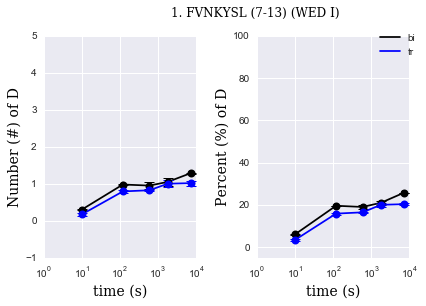

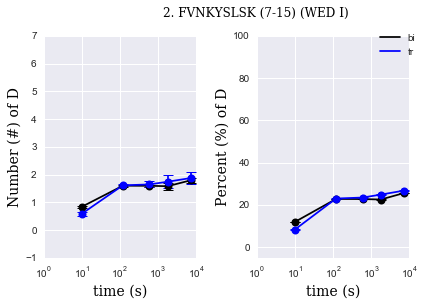

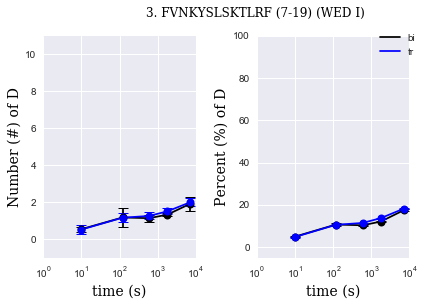

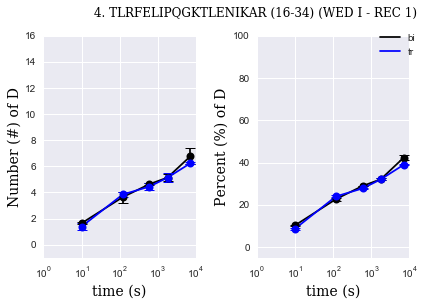

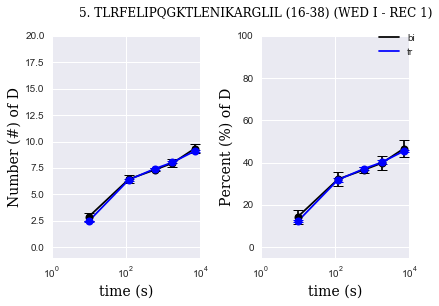

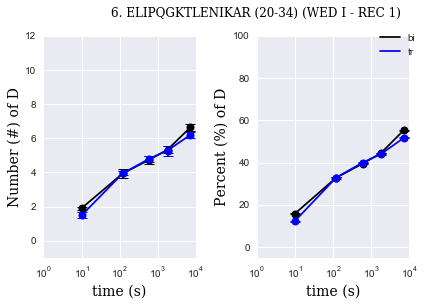

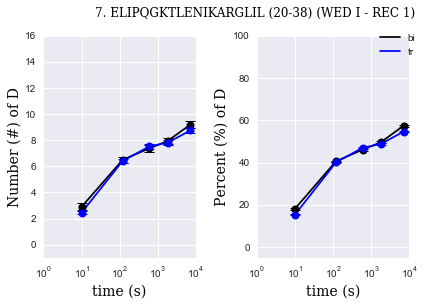

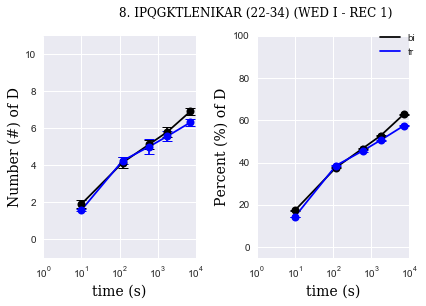

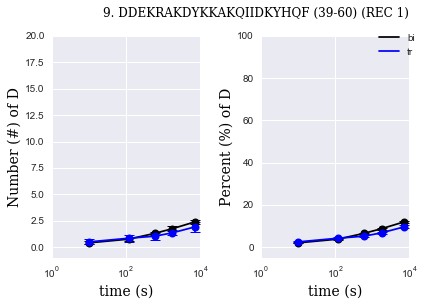

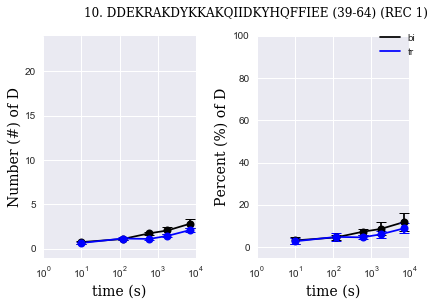

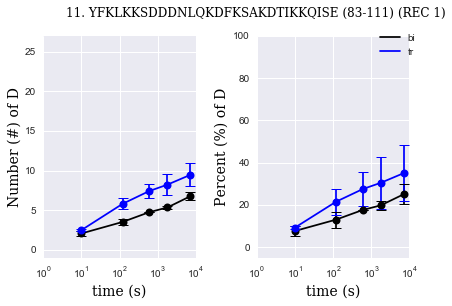

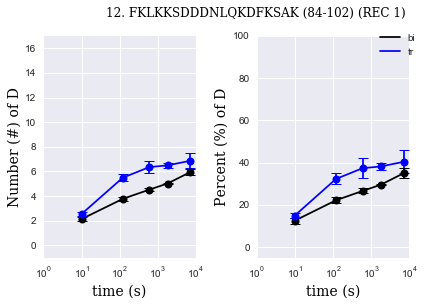

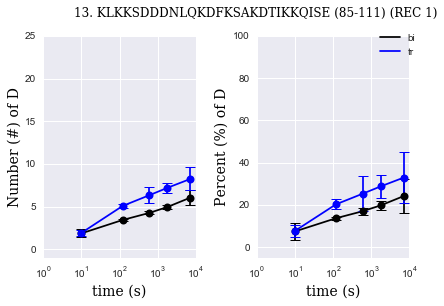

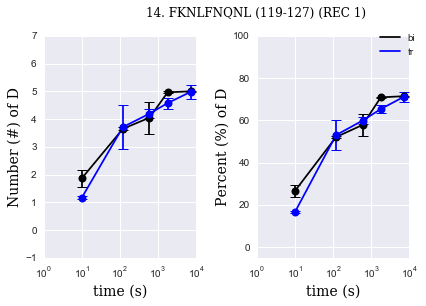

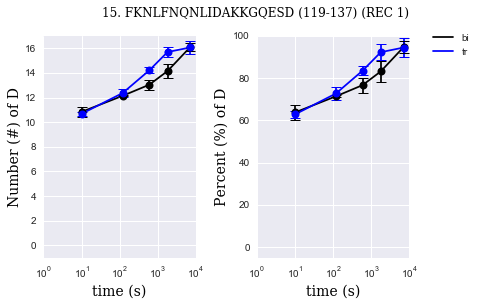

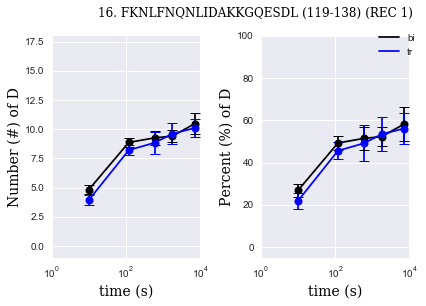

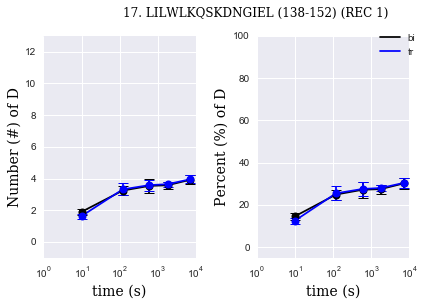

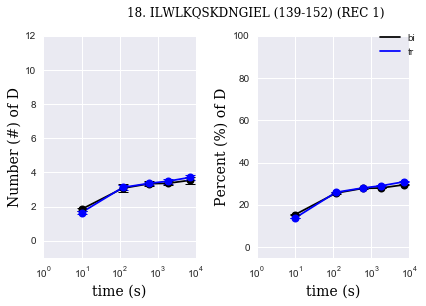

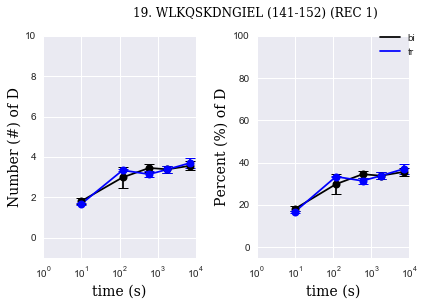

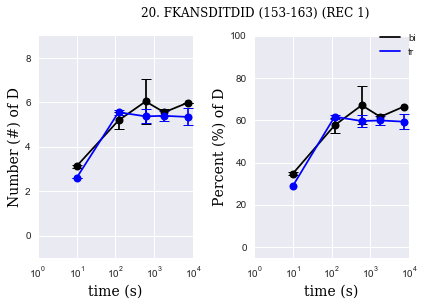

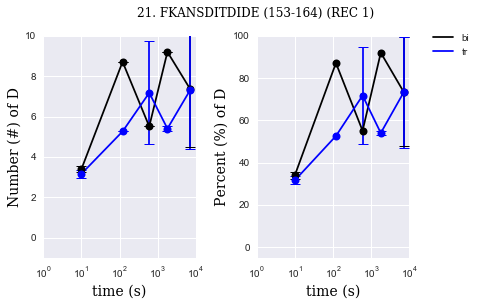

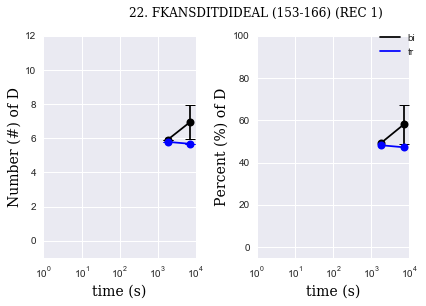

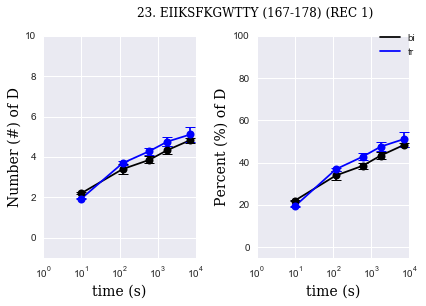

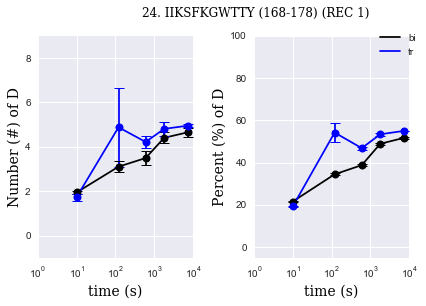

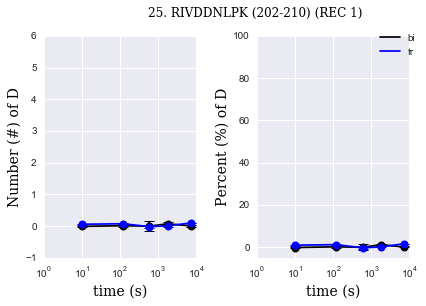

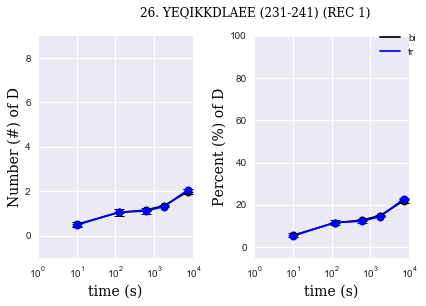

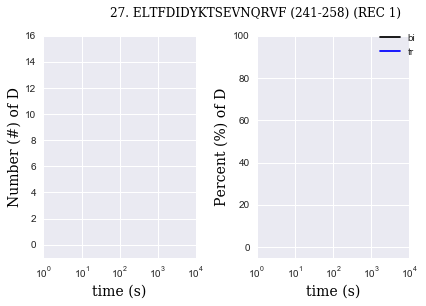

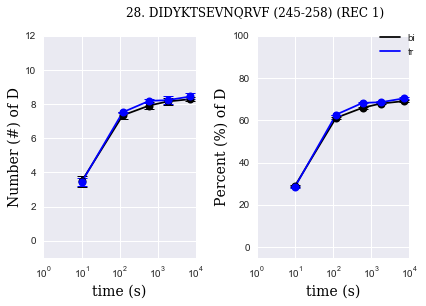

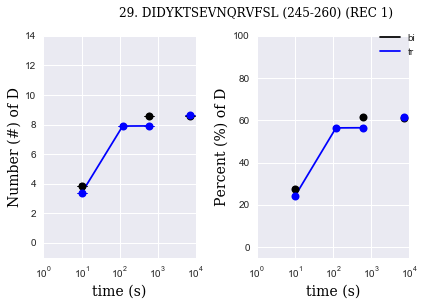

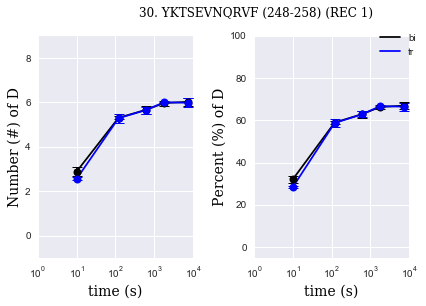

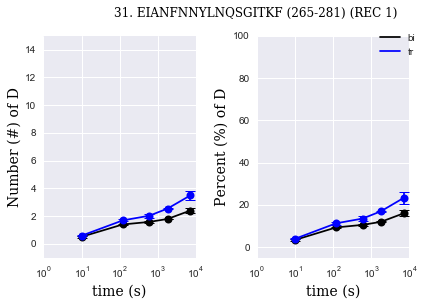

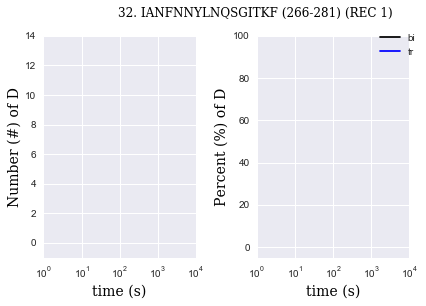

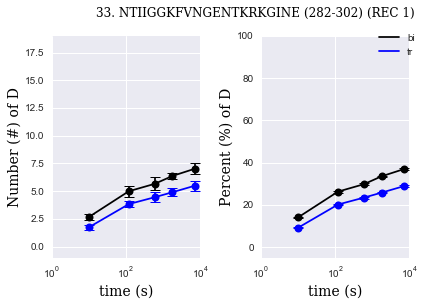

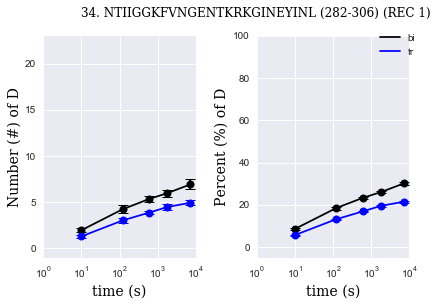

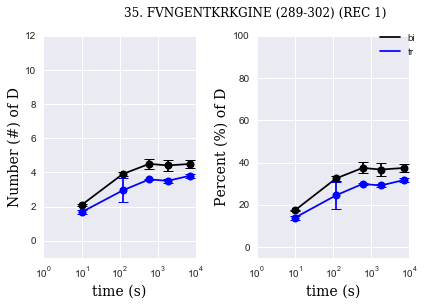

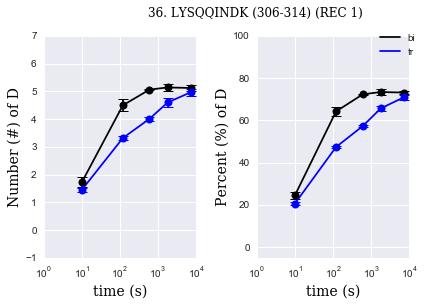

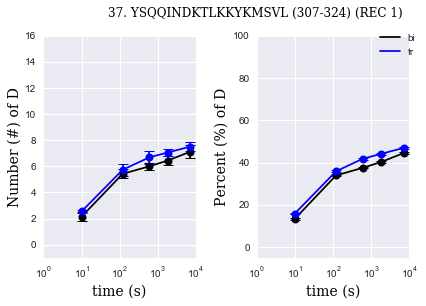

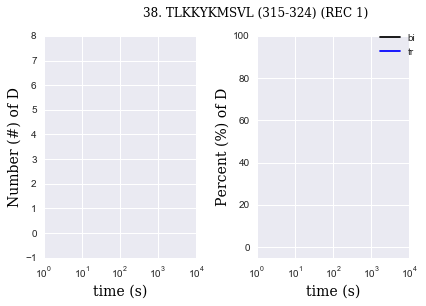

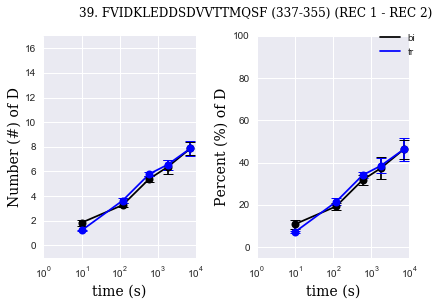

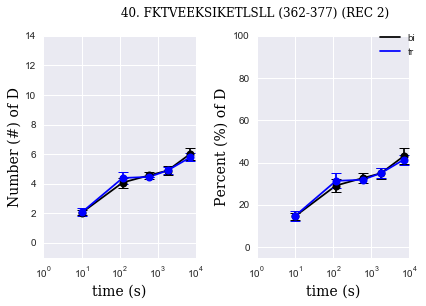

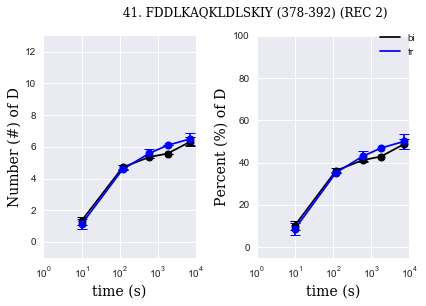

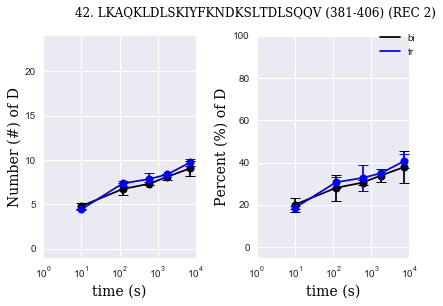

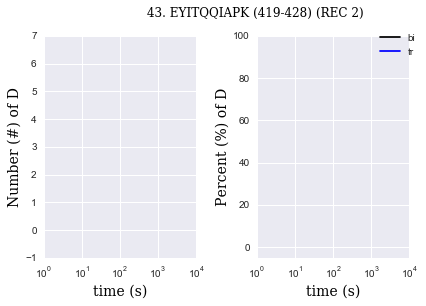

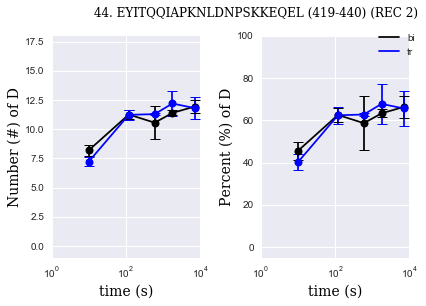

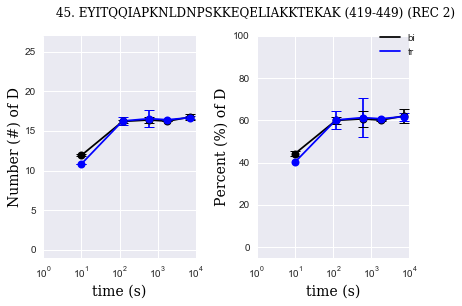

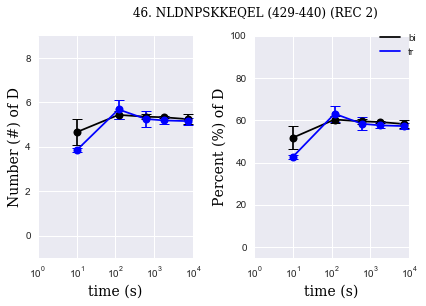

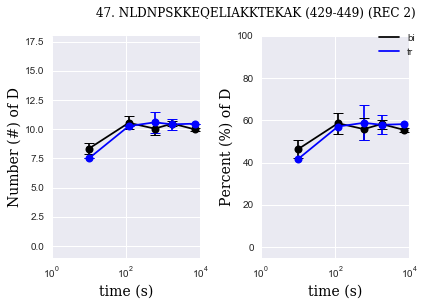

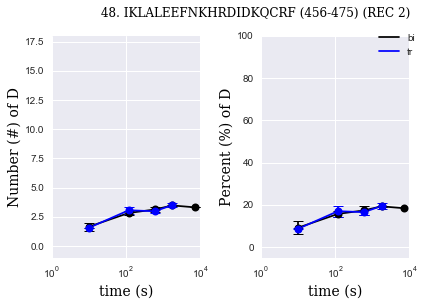

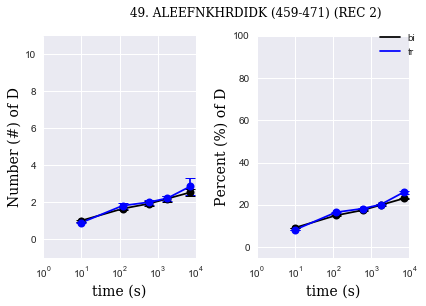

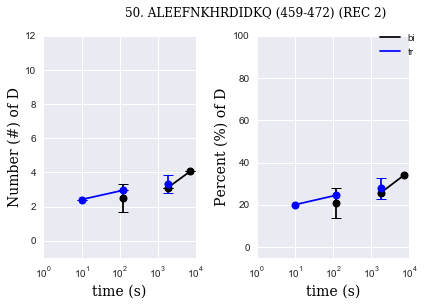

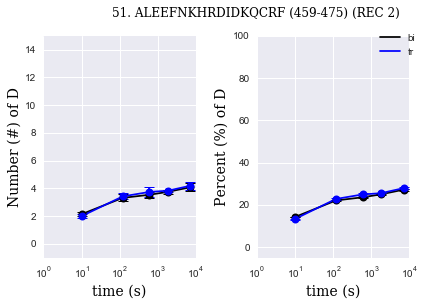

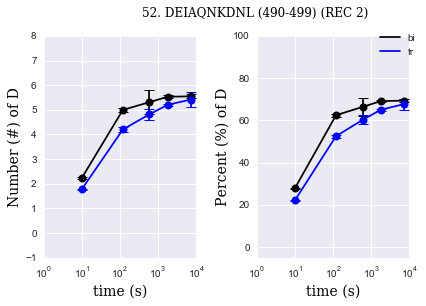

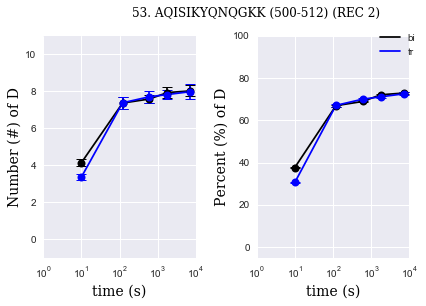

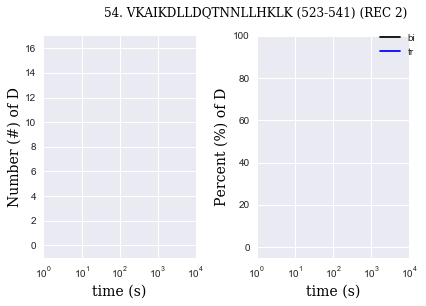

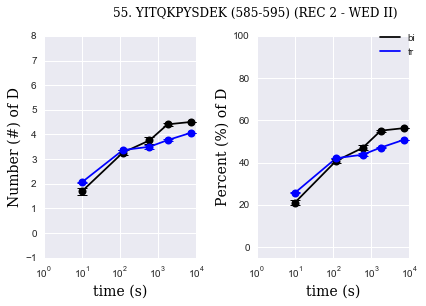

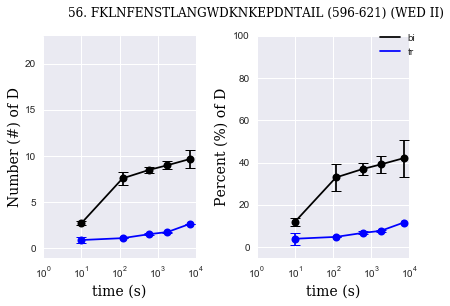

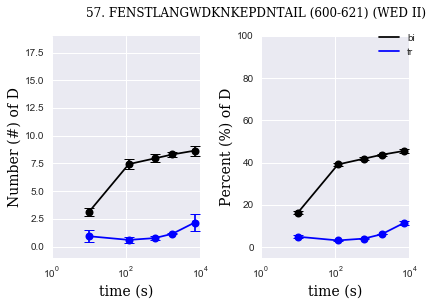

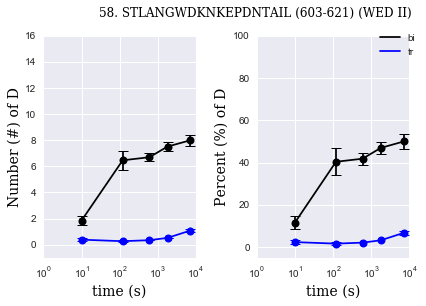

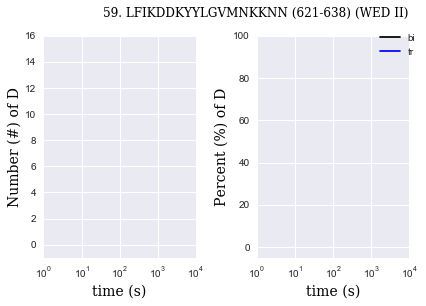

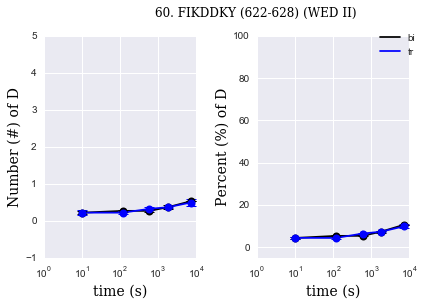

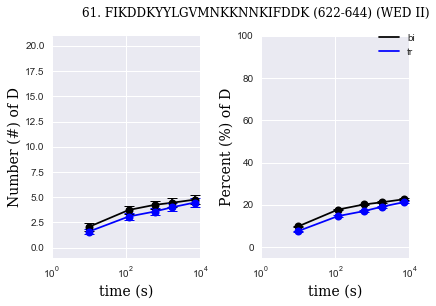

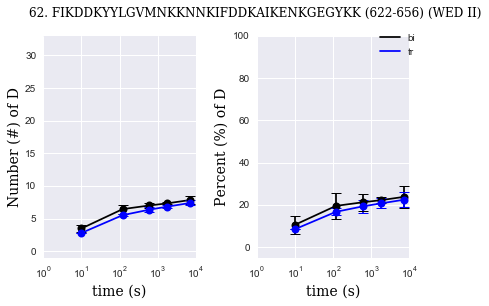

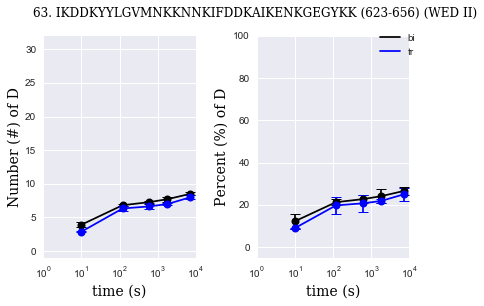

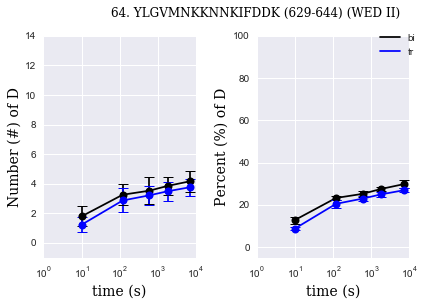

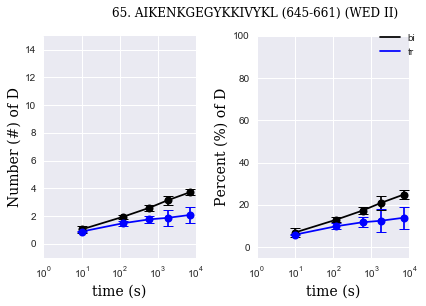

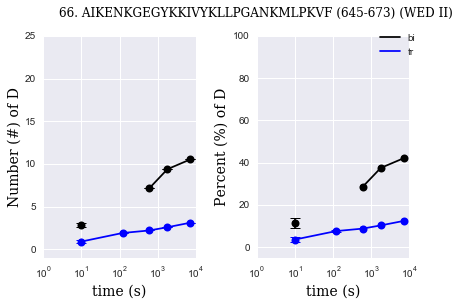

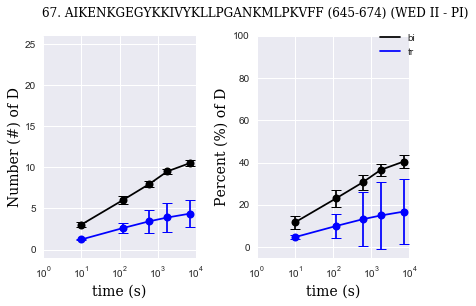

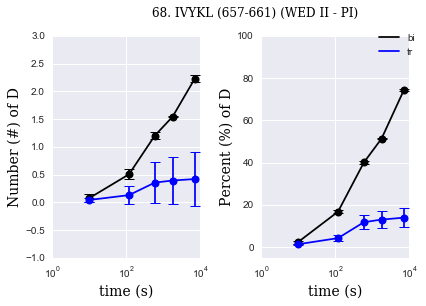

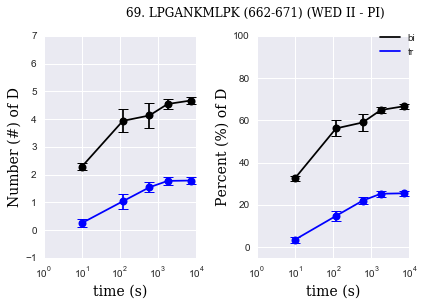

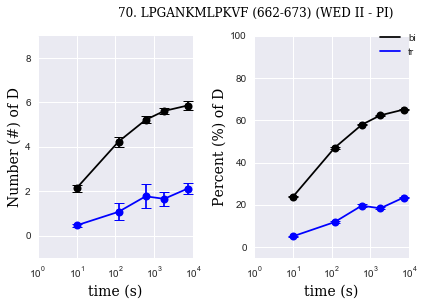

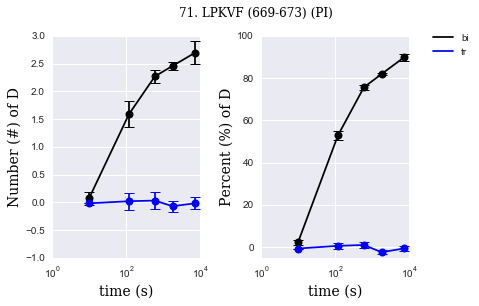

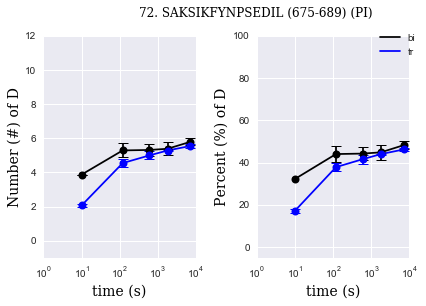

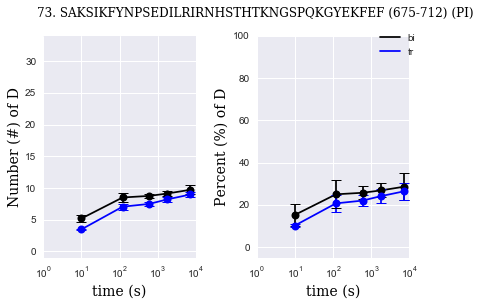

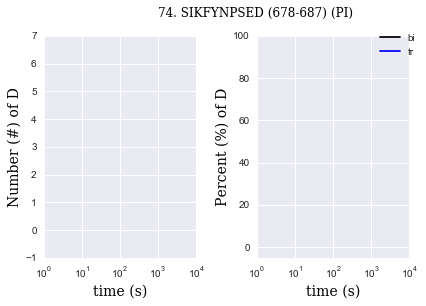

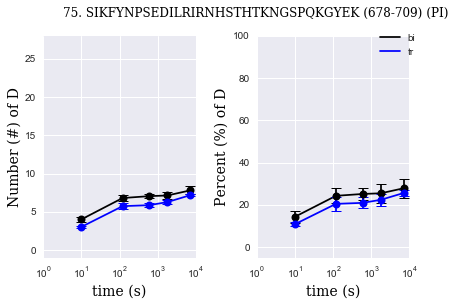

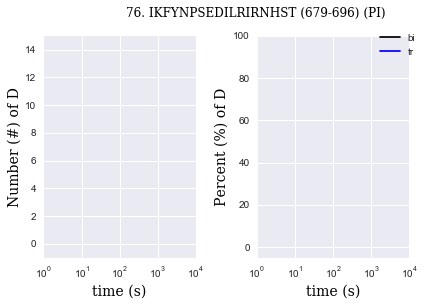

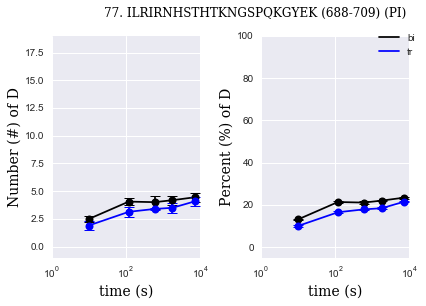

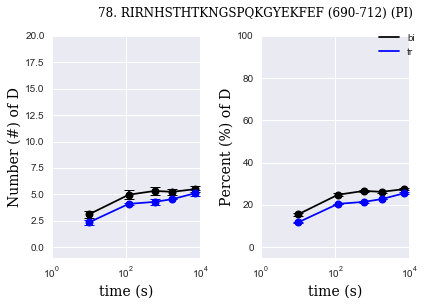

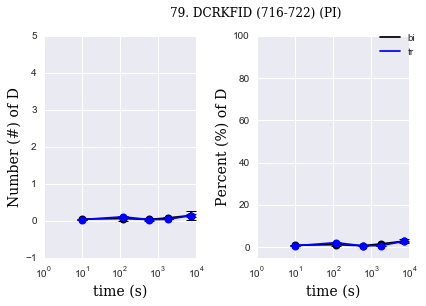

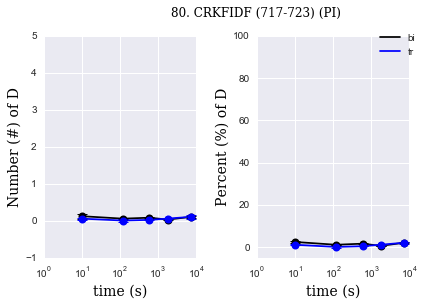

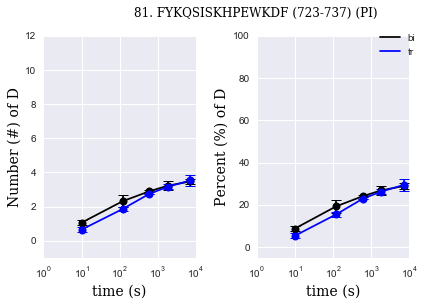

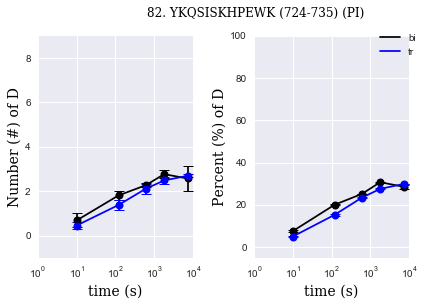

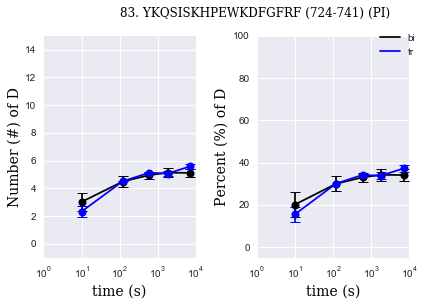

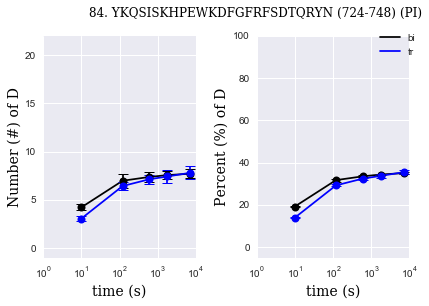

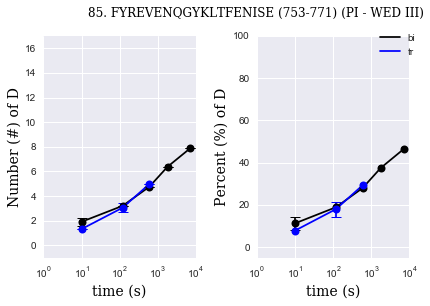

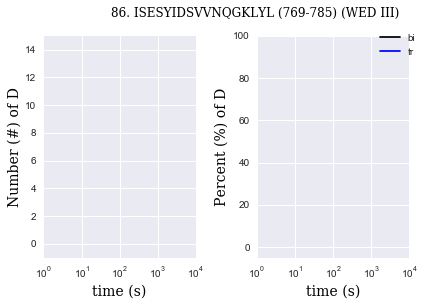

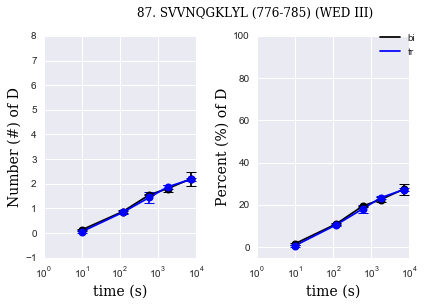

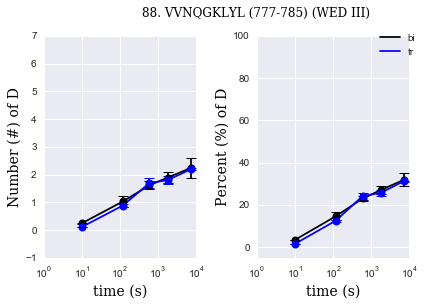

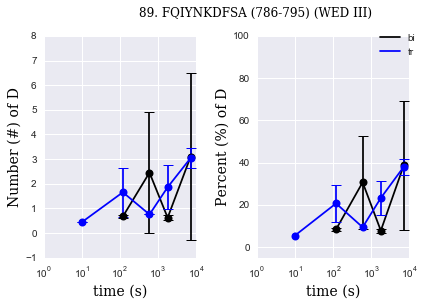

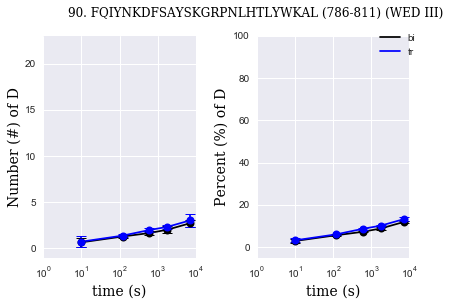

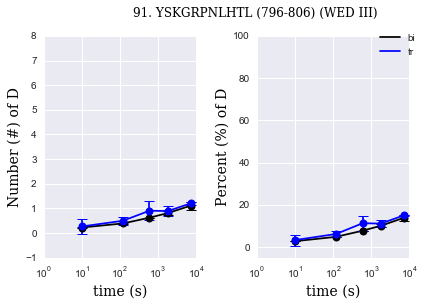

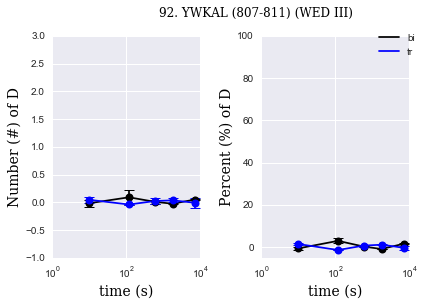

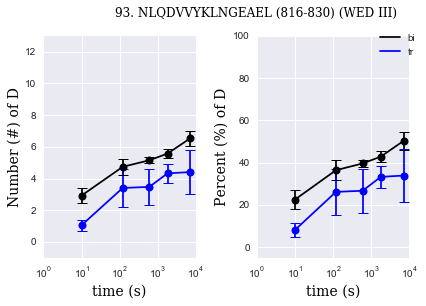

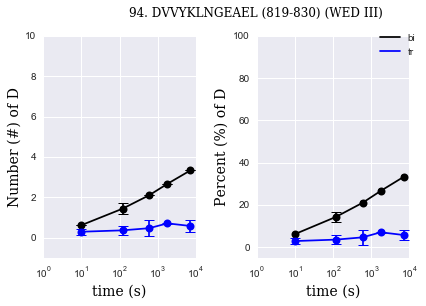

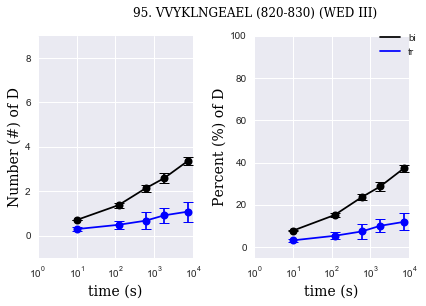

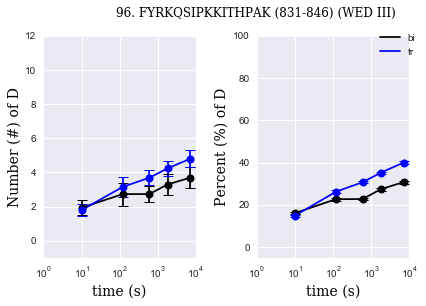

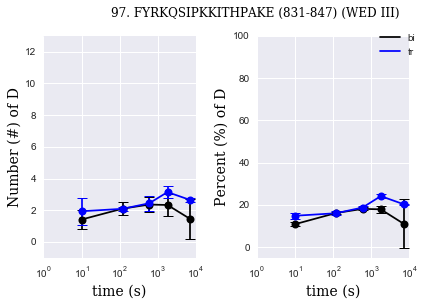

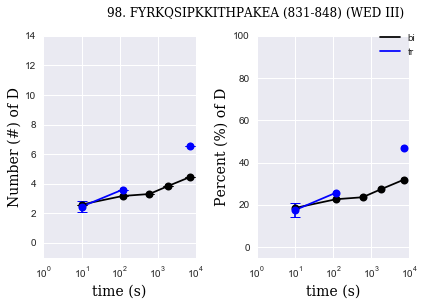

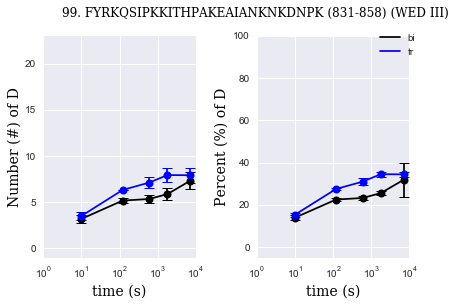

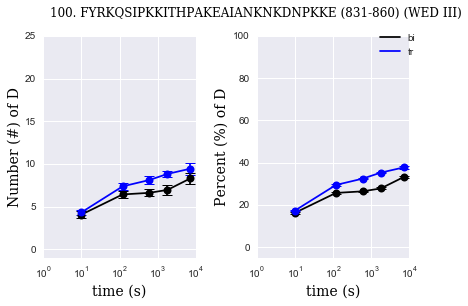

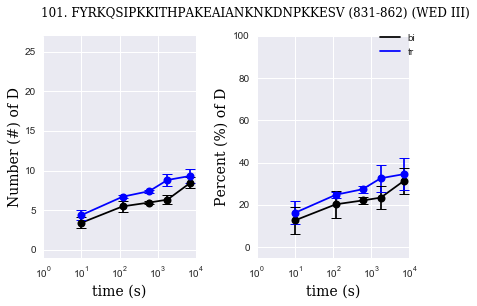

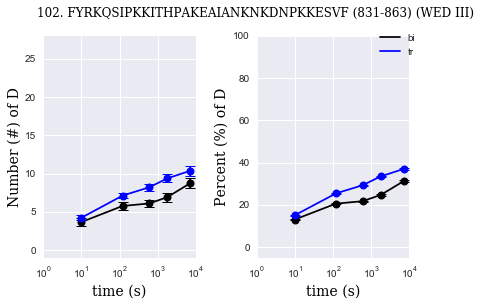

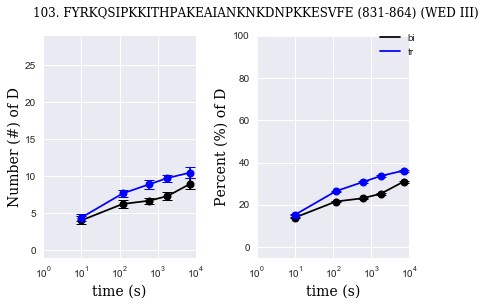

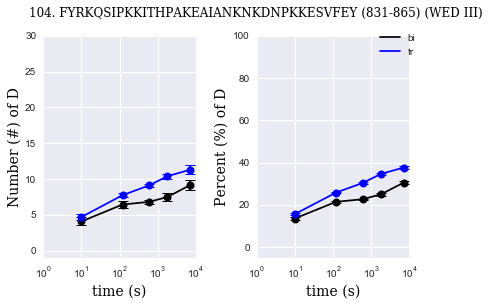

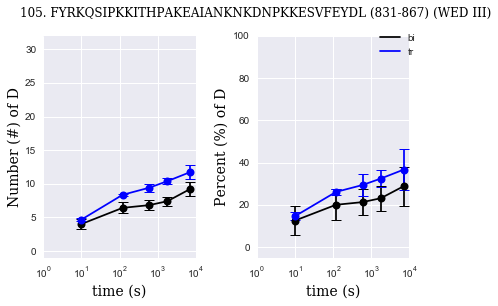

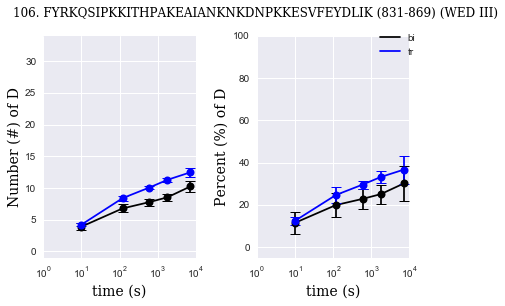

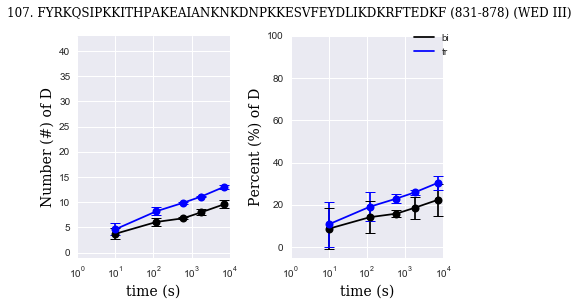

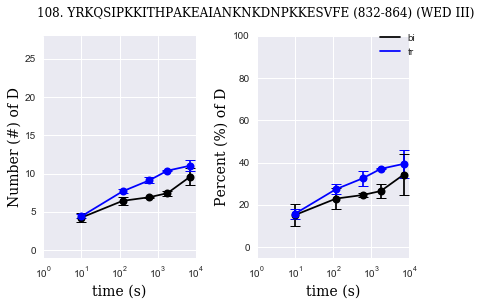

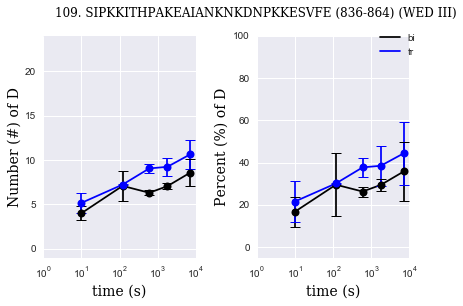

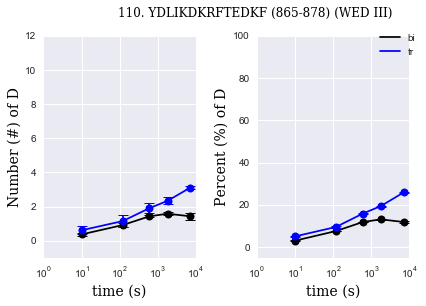

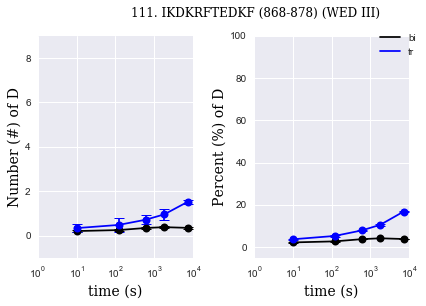

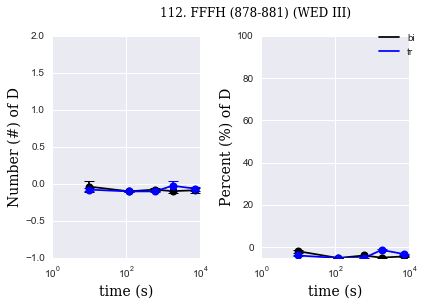

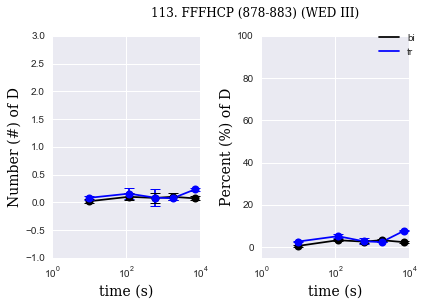

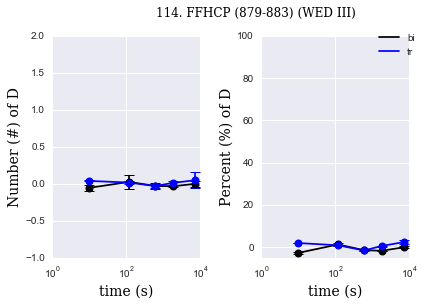

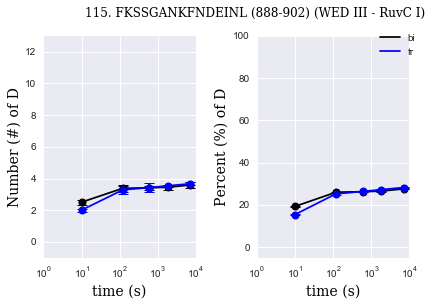

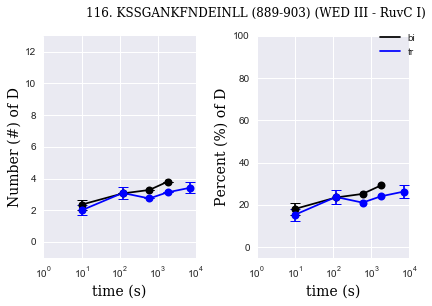

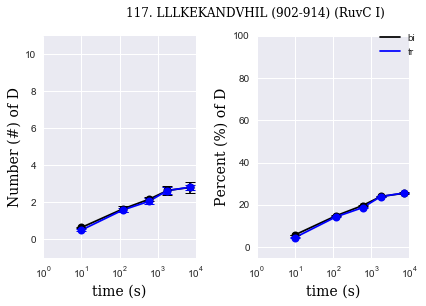

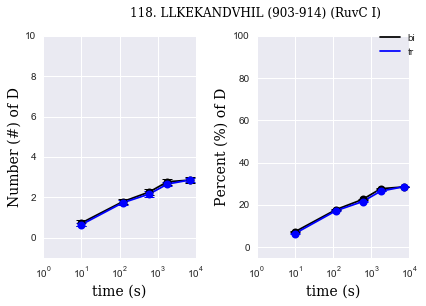

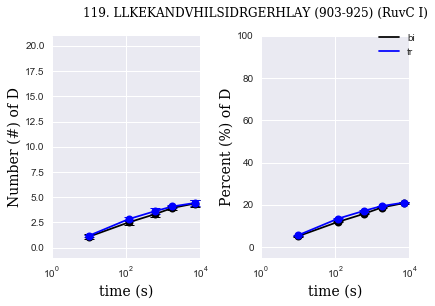

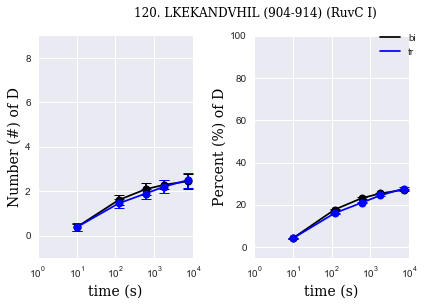

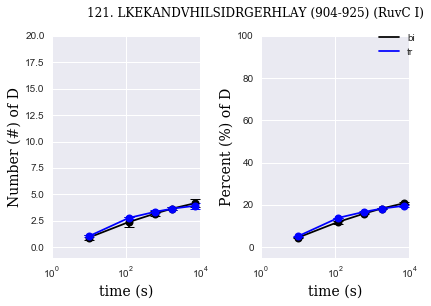

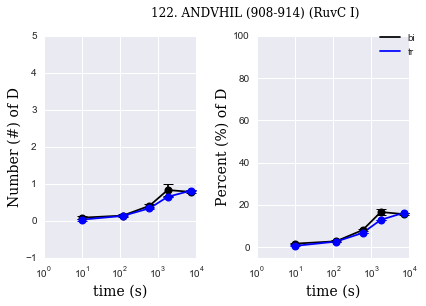

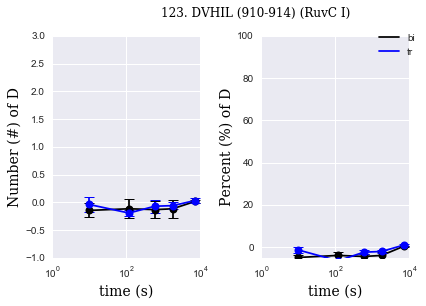

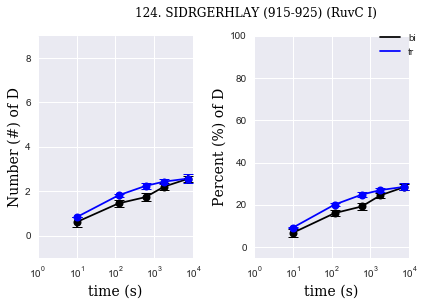

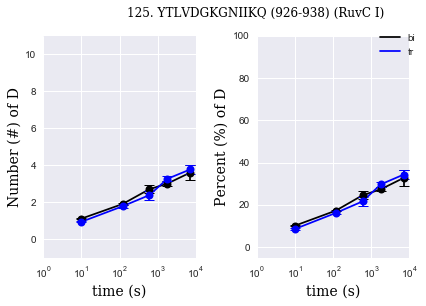

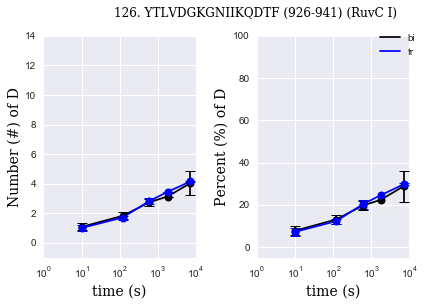

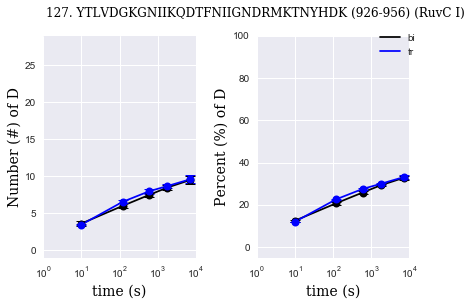

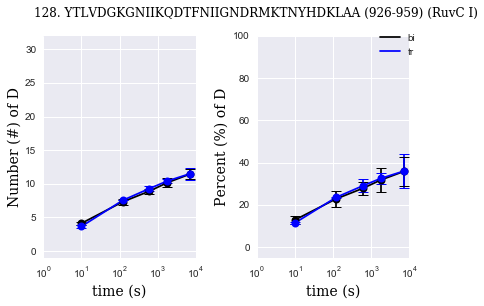

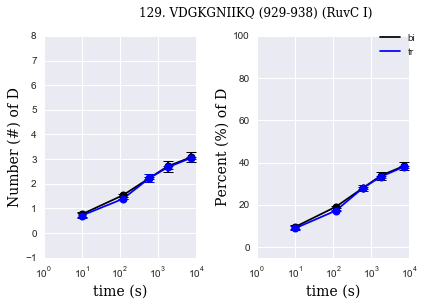

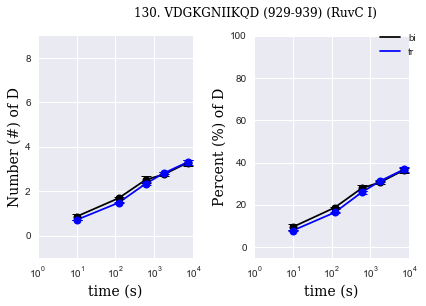

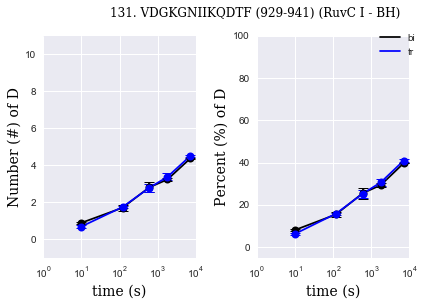

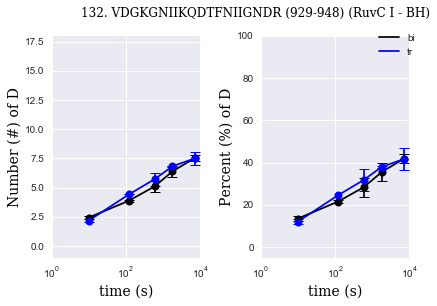

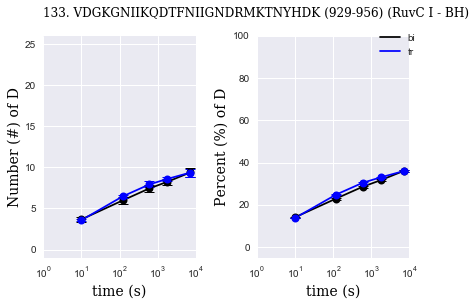

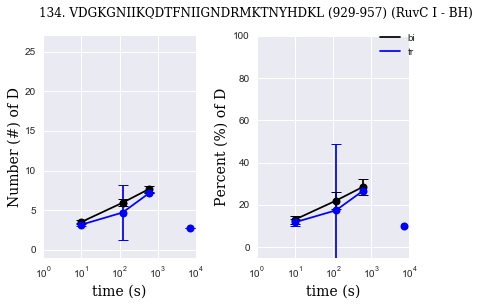

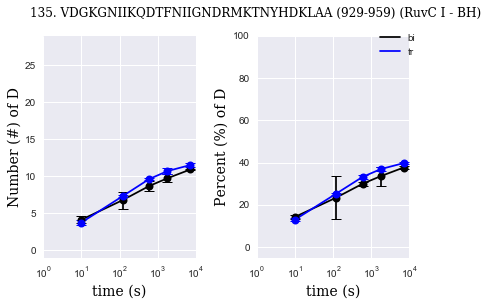

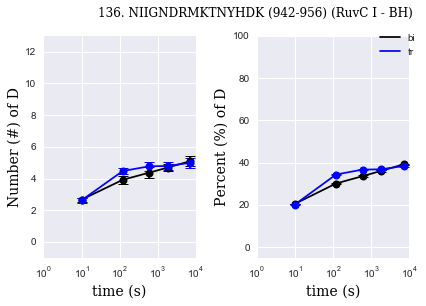

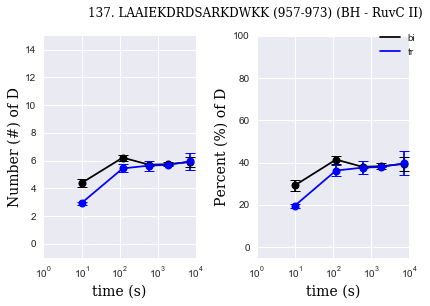

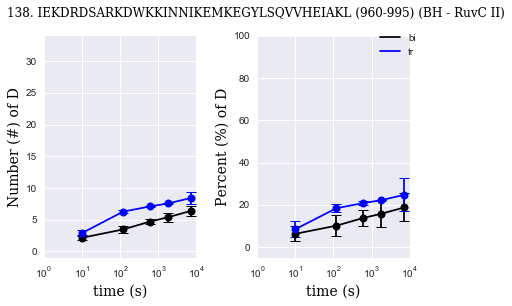

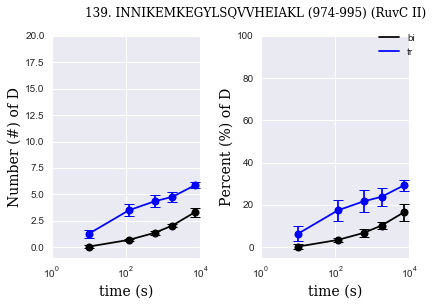

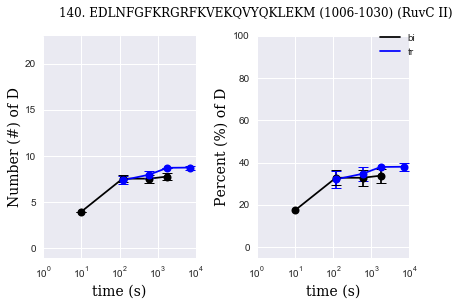

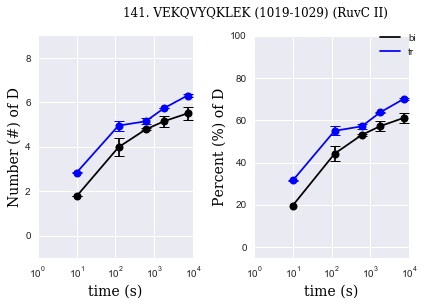

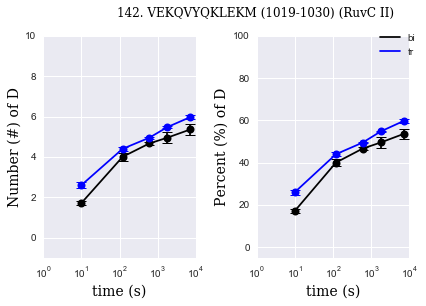

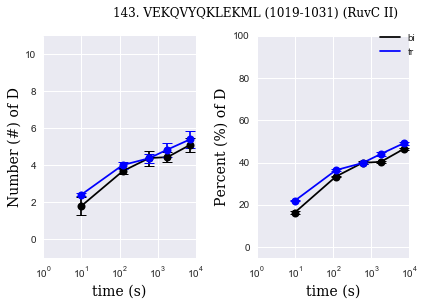

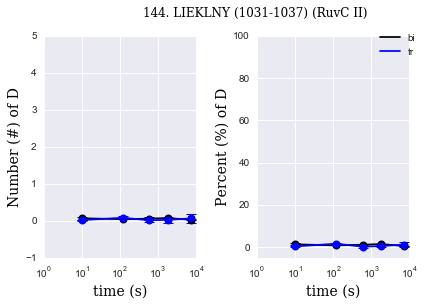

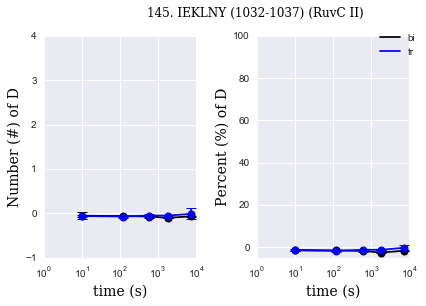

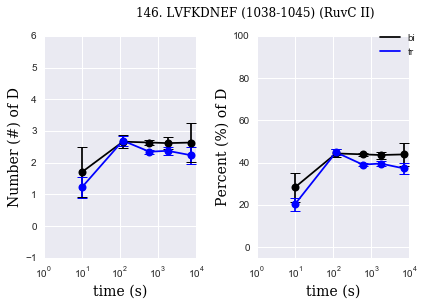

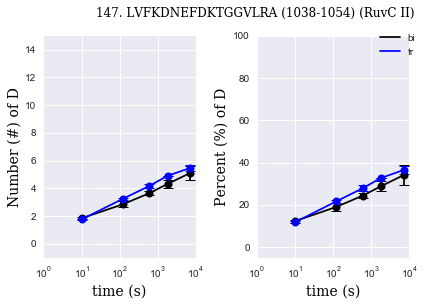

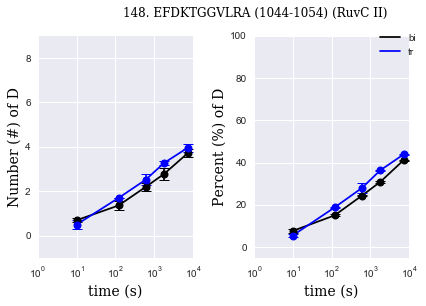

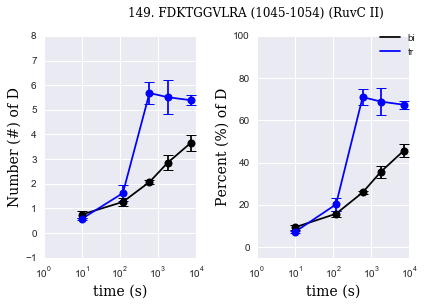

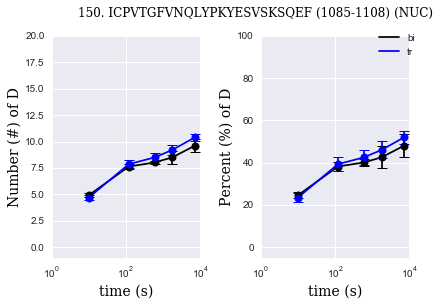

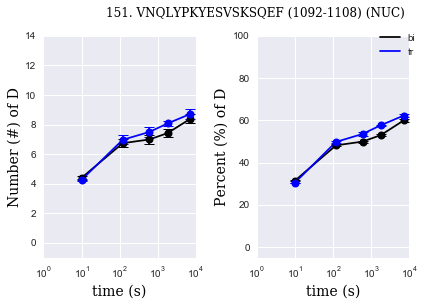

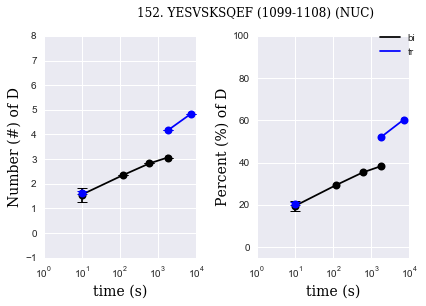

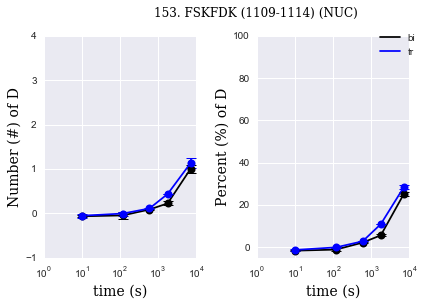

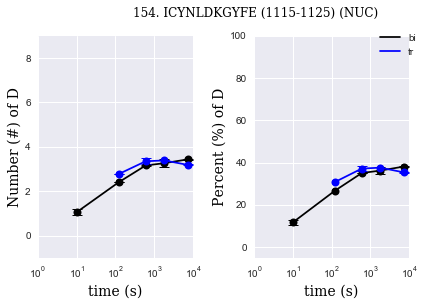

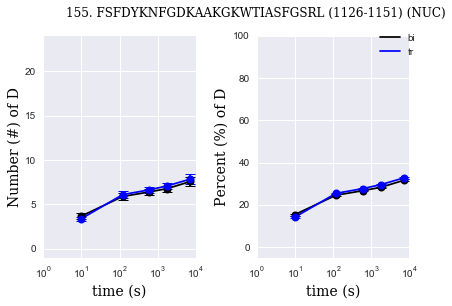

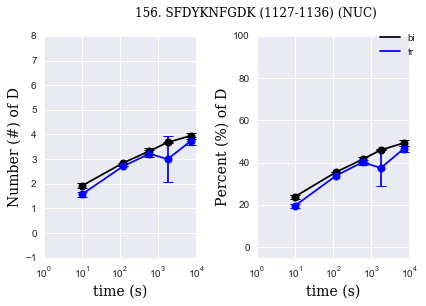

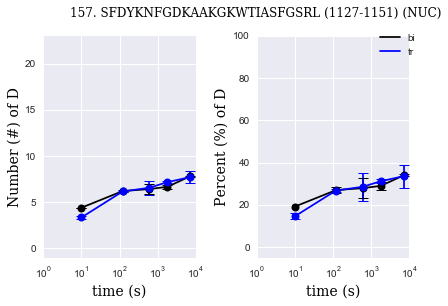

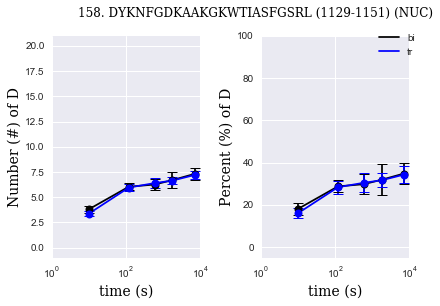

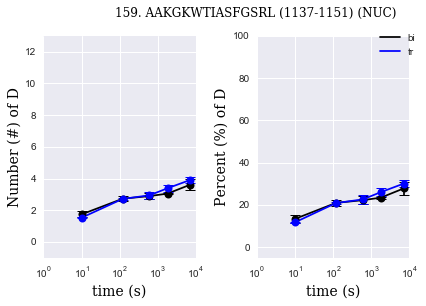

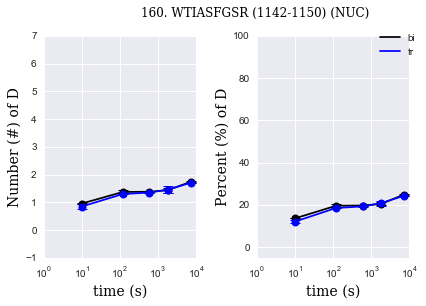

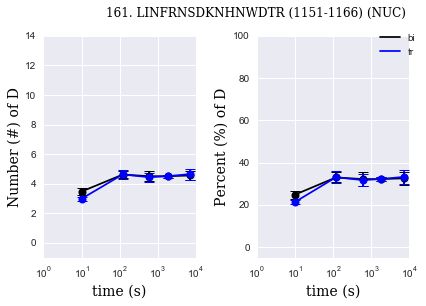

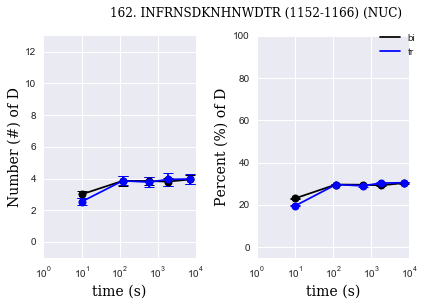

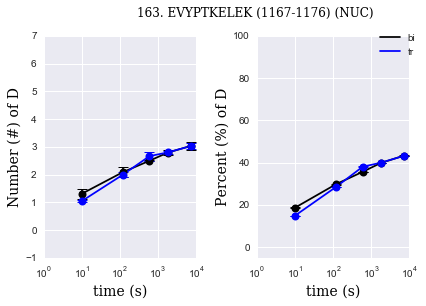

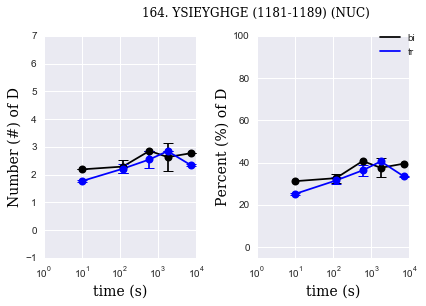

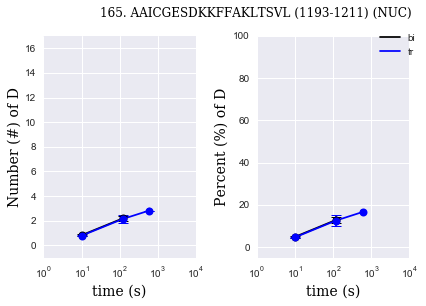

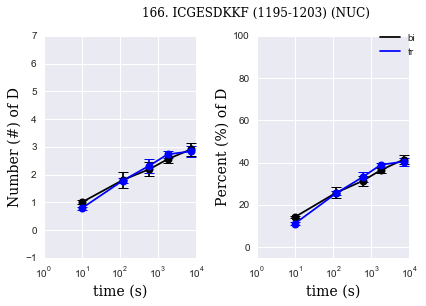

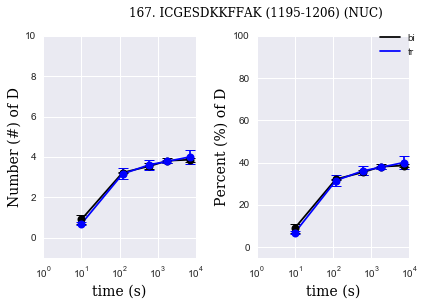

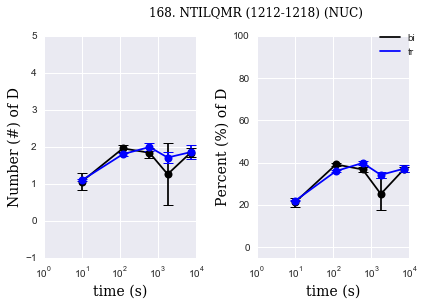

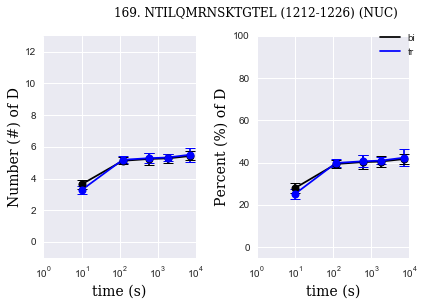

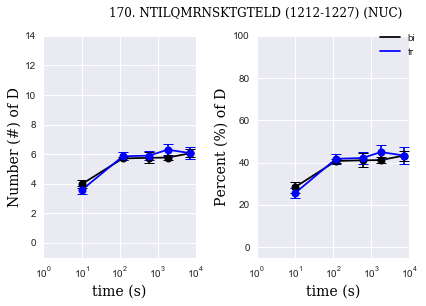

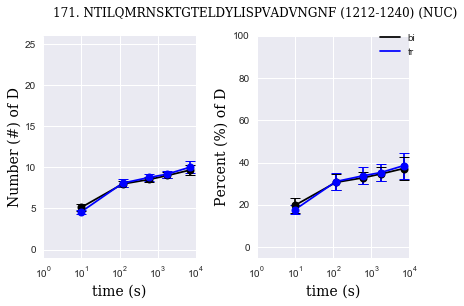

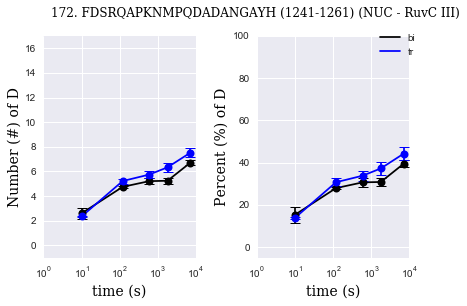

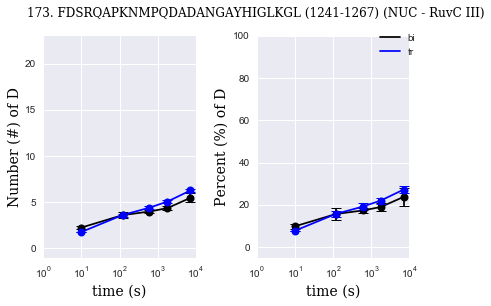

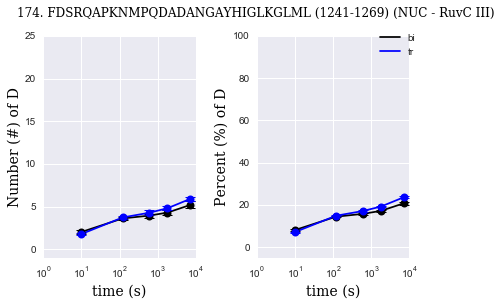

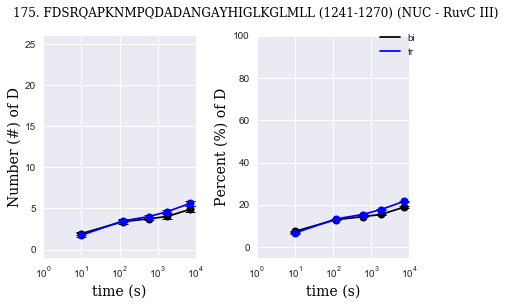

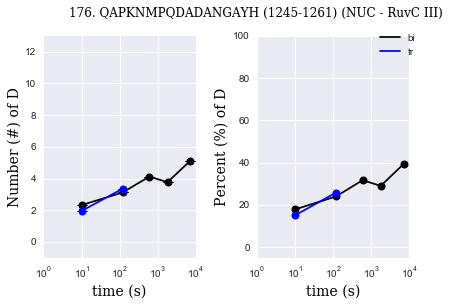

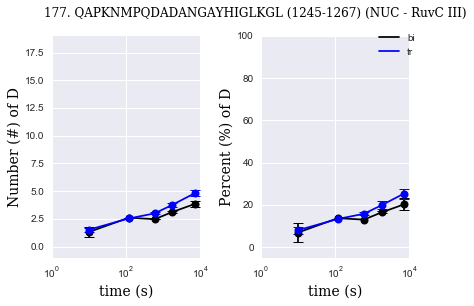

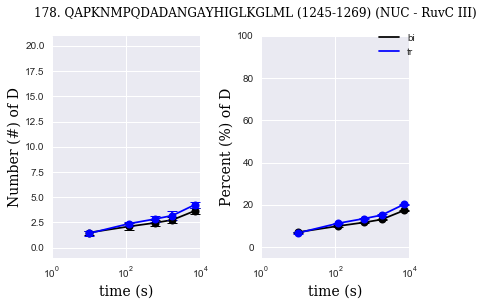

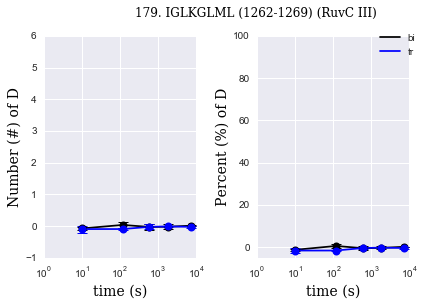

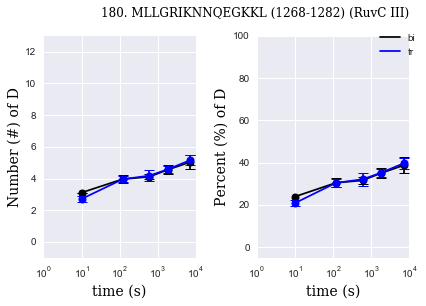

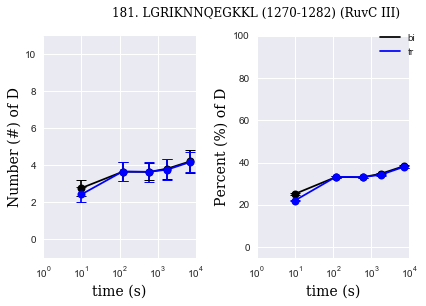

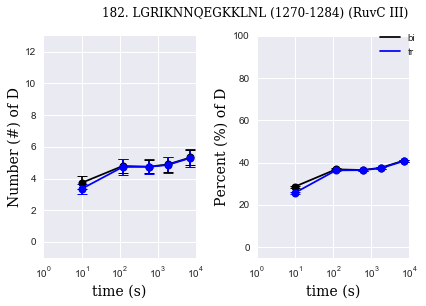

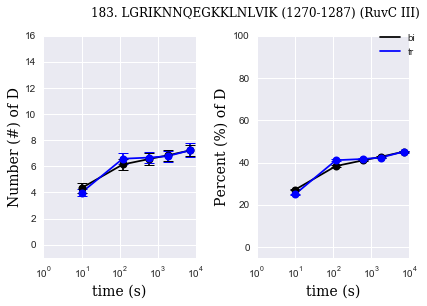

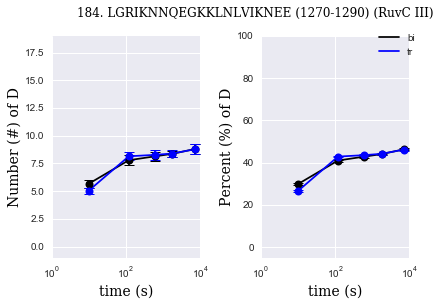

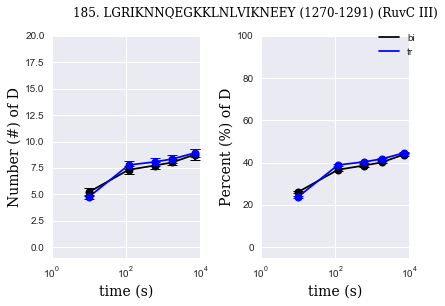

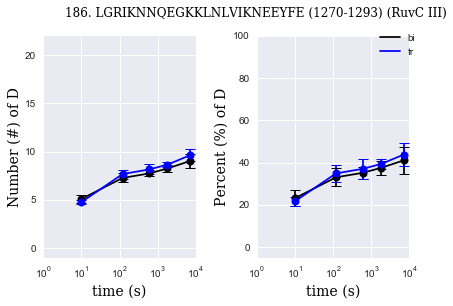

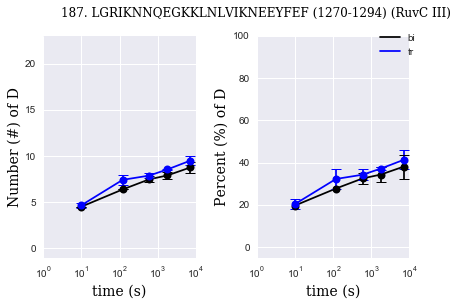

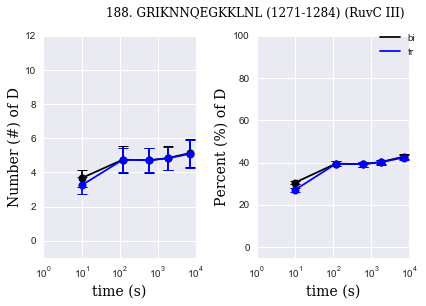

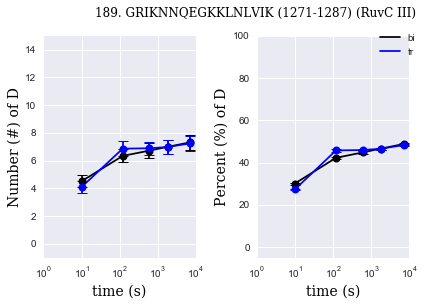

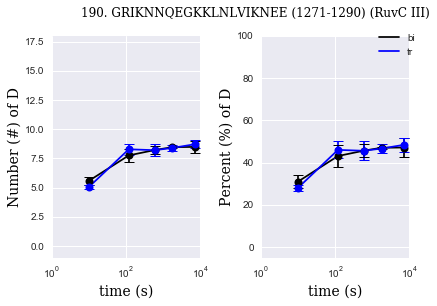

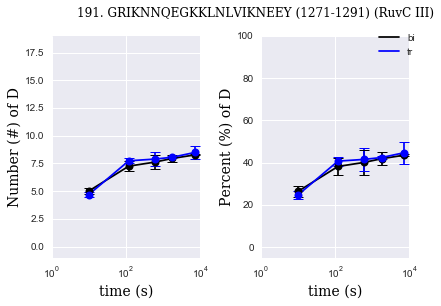

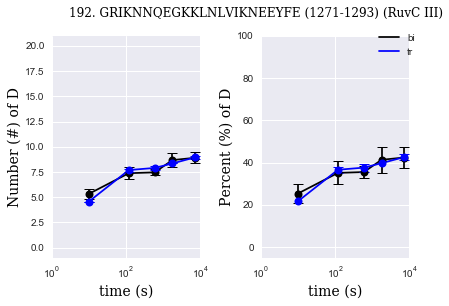

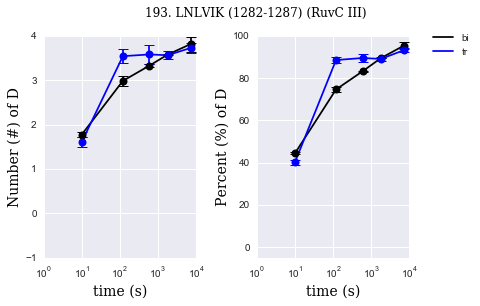

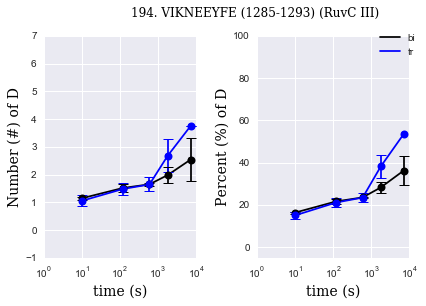

In [22]:
pl =plots()
df =pl.domains_mapping(df, pep_map, check =False)

states = ["bi", "tr"]
uptake_plots(df, states, kind = "both", tiff = False, path = None )

In [ ]:
pl =plots()
df =pl.domains_mapping(df, pep_map, check =False)
dmn = str(df.loc['1 (7-13)'].domains.unique()[0])
a

In [ ]:
na =""
for st in states:
    na = na + st + "-" 
    name = [i for i in na.split("-")]    
    name = name[:-1]
    name = "-".join(name)

kd = ["#D", "%D"]

both =[]
std = []
conf = []
for st in states:
    for k in kd:
        a = k + "_" + st
        s = 'Stddev'+ "_" + st
        c = 'Conf Interval (#D)'+ "_" + st
        both.append(a)
        std.append(s)
        conf.append(c)



number =both[:len(states)] 
percent = both[len(states):]
number, both

In [ ]:

with PdfPages('d(b,t)_pos_sig.pdf') as pdf: 
    
    for idx, p in zip(dab_pos_sig, dab_pos_sig_pep ):
        df2 = df1.loc[idx]


    # Create data percent of D  
        #a1 = (df2['Deut Time (sec)'], df2['#D_apo'])
        b = (df2['Deut Time (sec)'], df2['#D_apo'])
        c = (df2['Deut Time (sec)'], df2['#D_bi'])
        
    # Create data number of D

        #a = (df2['Deut Time (sec)'], df2['%D_apo'])
        db = (df2['Deut Time (sec)'], df2['delta(a,b)'])
        
        #a_std =  df2['Stddev_apo'].values.tolist()
        b_std =  df2['Stddev_apo'].values.tolist()
        c_std =  df2['Stddev_bi'].values.tolist()
        
        # Error for the differences

        db_std =  df2['delta(a,b),std'].values.tolist()

        
        errors = (b_std, c_std)
        

        
        data = (b, c)
        
        colors = ("blue", "red")
        groups = ("binary", "ternary") 

        # Create plot

        f, (ax1, ax2) = plt.subplots(1, 2 )

        
        # Ploting #D plot
        
        for data, color, group, error in zip(data, colors, groups, errors):
            x, y = data
            ax1.scatter(x, y, c=color, edgecolors='none', s=30, label = None )
            ax1.plot(x,y,c=color, label = group)

            (_, caps, _) = ax1.errorbar(x, y, yerr=error, fmt='o', markersize=8, capsize=5, label = None, c= color)

            for cap in caps:
                cap.set_markeredgewidth(1)
        
        # Plotting the differences       

        x, y = db
        ax2.scatter(x, y, c='black', edgecolors='none', s=30, label = None )
        ax2.plot(x,y,c='black', label = group)

        (_, caps, _) = ax2.errorbar(x, y, yerr=db_std, fmt='o', markersize=8, capsize=5, label = None, c= "black")

        for cap in caps:
            cap.set_markeredgewidth(1)

        ax1.set_xscale('log')
        ax2.set_xscale('log')
        
        ax1.set_xlim(1, 10000)
        ax2.set_xlim(1, 10000)

        
        ax1_min, ax1_max = ax1.set_ylim(-0.5)
        ax2.set_ylim(ax1_min, ax1_max)
        

        font = {'family': 'serif','color':  'black', 'weight': 'normal','size': 14}
        font_t = {'family': 'serif','color':  'black', 'weight': 'normal','size': 10}
        plt.rc("font")
         


        ax1.set_xlabel('time (s)', fontdict = font)
        ax2.set_xlabel('time (s)', fontdict = font)
        
        ax1.set_ylabel("#D",fontdict = font)
        ax2.set_ylabel("$\Delta (bi,tr)$",fontdict = font)

        
        
        # Setting a common Legend out of the box
        legend = ax1.legend(fontsize = 10, bbox_to_anchor=(1.1, 1.05))
        
        
        title = plt.suptitle(p, x = 0.6, y=1.05, fontdict = font_t)
        
        
        f.tight_layout()
        plt.tight_layout()

        #pdf.savefig(dpi=300, bbox_extra_artists=(legend, title), bbox_inches='tight')

        
        #plt.savefig("HDX_PLOTS/"+ p + ".tif", dpi=300, bbox_extra_artists=(legend, title), bbox_inches='tight' )        
        
        plt.show()

In [ ]:
# Fishing out peptides whose has significant changes betn binary and ternary complexes (more than error and 1 da)
# for positive changes

dab_pos_sig = df1.loc[pos_pep_idx_dab][
    (
        df1.loc[pos_pep_idx_dab][
        "delta(a,b)"].round(1)
     >
     df1.loc[pos_pep_idx_dab][
         "delta(a,b),std"].round(1)
    )
    &
    (
        df1.loc[pos_pep_idx_dab][
        "delta(a,b)"].round(1)
     >1
    )
].index.unique()

dab_pos_sig_pep = df1.loc[pos_pep_idx_dab][
    (
        df1.loc[pos_pep_idx_dab][
        "delta(a,b)"].round(1)
     >
     df1.loc[pos_pep_idx_dab][
         "delta(a,b),std"].round(1)
    )
    &
    (
        df1.loc[pos_pep_idx_dab][
        "delta(a,b)"].round(1)
     >1
    )
].pepn_idx.unique()

# for negative changes
dab_neg_sig = df1.loc[neg_pep_idx_dab][
    (
        df1.loc[neg_pep_idx_dab][
        "delta(a,b)"].round(1)
     <
     df1.loc[neg_pep_idx_dab][
         "delta(a,b),std"].round(1)
    )
    &
    (
        df1.loc[neg_pep_idx_dab][
        "delta(a,b)"].round(1)
     >1
    )
].index.unique()

dab_pos_sig_pep = df1.loc[pos_pep_idx_dab][
    (
        df1.loc[pos_pep_idx_dab][
        "delta(a,b)"].round(1)
     >
     df1.loc[pos_pep_idx_dab][
         "delta(a,b),std"].round(1)
    )
    &
    (
        df1.loc[pos_pep_idx_dab][
        "delta(a,b)"].round(1)
     >1
    )
].pepn_idx.unique()


In [ ]:
dbt_neg_sig

In [ ]:
df1.loc[pos_pep_idx]

In [ ]:
df1.index[(df1["delta(b,t)"].round(1)>df1["delta(b,t),std"].round(1)) & (df1["delta(b,t)"].round(1)>1) ].unique()


In [ ]:
# Initialize the matplotlib figure
f, (ax1,ax2,ax3) = plt.subplots(nrows=3, figsize=(10, 10),sharex= True,sharey =True)
sns.set(style="whitegrid")

# Plot the t= 10s 
sns.set_color_codes("pastel")
ax1 = sns.barplot(y='delta(b,t)', x='pepn_idx', data=df1_pos1[df1_pos1['Deut Time (sec)'] ==10],
             label = "10s", color="r", dodge =False, ax =ax1)
# ax1.set_xticks([])

# Plot the t= 10mins
sns.set_color_codes("muted")
ax2 = sns.barplot(y='delta(b,t)', x='pepn_idx', data=df1_pos1[df1_pos1['Deut Time (sec)'] ==120],
            color="r", label = "10 mins", dodge =False, ax =ax2)
ax2.set_xticks([])

# Plot the t= 2 hrs
sns.set_color_codes("dark")
ax3 =sns.barplot(y='delta(b,t)',x='pepn_idx', data=df1_pos1[df1_pos1['Deut Time (sec)'] ==7200],
             color="r", label = "2 hrs" ,dodge =False, ax = ax3)


# Add a legend and informative axis label
axis_label=df1_pos1[df1_pos1['Deut Time (sec)'] ==10].pepn_idx.tolist()

for ax in ax1,ax2,ax3:
    
    ax.legend(loc= "upper right", frameon=False,fontsize=15)
    ax.set(ylim=(0, 10), xlabel="")

for ax in ax1,ax2,ax3:
    ax.set_ylabel("Number of D",fontsize=15)

locs, labels = plt.xticks()

plt.xticks(np.arange(12), axis_label, rotation=90, fontsize=15)
#plt.xls(axis_label, rotation=90, ha="right", fontsize=15)

#sns.despine(left=True, bottom=True)

#plt.tight_layout()
plt.savefig("barplot1.pdf", dpi=500, bbox_extra_artists=(ax1,ax2,ax3), bbox_inches='tight')

